# LSI31003 Machine Learning in Molecular Biology Assignment 2

#### I added the brief tittles above each code box for easier reading through;

# Introduction

We will continue on the mutational signatures theme but now the task is to infer the signatures de novo. Problem 1 does this from simulated data where we of course know the correct answer. In problem 2, we use data as given in assignment 1 from "Alexandrov LB, et al. (2013) Signatures of mutational processes in human cancer. Nature 500(7463):415–421".

In [2]:
library(ggplot2)
library(rBeta2009)
library(grid)
library(repr)
library(reshape2)
library(Rmisc)
library(ggpmisc)
library(gplots)
library(pastecs)
library(NMF)
library(dendextend)
library(latticeExtra)

#### Loding data

In [3]:
data_path<-"/Users/qingli/Desktop/Course/MLinMolecularBiology/Exercise/data/"
## channels96.csv contains the cosmic signature  
channels96<-paste(data_path,"MutSigCancer/channels96.csv",sep="")
channels96<-read.csv(channels96)

somatic<-paste(data_path,"MutSigCancer/somaticMutations.csv",sep="")
somaticMutations<-read.csv(somatic)

cosmic<-paste(data_path,"MutSigCancer/cosmic30.csv",sep="")
cosmic30<-read.csv(cosmic)

#### Print head of the data

In [4]:
##channels96<-read.csv("data/MutSigCancer/channels96.csv")
##somaticMutations<-read.csv("data/MutSigCancer/somaticMutations.csv")
##cosmic30<-read.csv("data/MutSigCancer/cosmic30.csv",header=F)

data_path<-"/Users/qingli/Desktop/Course/MLinMolecularBiology/Exercise/data/"
channels96<-paste(data_path,"MutSigCancer/channels96.csv",sep="")
channels96<-read.csv(channels96)

somatic<-paste(data_path,"MutSigCancer/somaticMutations.csv",sep="")
somaticMutations<-read.csv(somatic)

cosmic<-paste(data_path,"MutSigCancer/cosmic30.csv",sep="")
cosmic30<-read.csv(cosmic)

known_sig<-t(cosmic30)
## change the colunm names of somaticMutations(because those like "@|>" are converted into "." by python):
colnames(somaticMutations)<-c("cancer_type",as.character(channels96$mutation))

## head of the data files:
head(channels96,2)
head(somaticMutations,2)
head(cosmic30,2)
rownames(known_sig)<-NULL
colnames(known_sig)<-NULL

mutation.type,mutation.context,mutation
C>A,A_A,C>A@A_A
C>A,A_C,C>A@A_C


cancer_type,C>A@A_A,C>A@A_C,C>A@A_G,C>A@A_T,C>A@C_A,C>A@C_C,C>A@C_G,C>A@C_T,C>A@G_A,⋯,T>G@C_G,T>G@C_T,T>G@G_A,T>G@G_C,T>G@G_G,T>G@G_T,T>G@T_A,T>G@T_C,T>G@T_G,T>G@T_T
ALL,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ALL,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95
0.0110983262,0.0091493407,1.490070e-03,0.0062338852,0.006595870,0.007342368,8.928404e-04,0.0071865816,0.0082326040,0.0057580214,⋯,0.0015995485,2.758538e-03,9.904500e-05,2.023656e-04,0.0011883532,8.007233e-04,1.397554e-03,1.291737e-03,0.0020310769,0.0040301282
0.0006827082,0.0006191072,9.927896e-05,0.0003238914,0.000677445,0.000213681,6.770460e-06,0.0004163329,0.0003520134,0.0001338169,⋯,0.0002282459,6.711134e-05,9.555239e-05,4.700238e-05,0.0001099257,8.647718e-05,7.173695e-05,1.428146e-05,0.0002066152,0.0000235982


### Problem 1: Inference from simulated data <a id='Problem1'></a>

#### Problem 1a: 
Generate simulated data sets using a subset (varying the number between 4-10) of the 30 signatures given above.

#### Code module -- Simulation of mutational processes:

In [5]:
#### The function below will take four arguments. mean_activity_num, total_count, given signature,model

#### It will produce a list, which contains:

##### 1) only one simulated sample for the given arguments
##### 2) the picked index of given cosmic signatures
##### 3) the contribution of the used signatures 

simulate_mutational_process<-function(mean_activity_num=4,total_count,cosmic,model="poisson",seed){
    set.seed(seed)
    poisson_array<-round(rpois(30,mean_activity_num))
    constrains_activity_number<-dim(cosmic)[1]+1
    activity_num<-poisson_array[poisson_array>2 & poisson_array<constrains_activity_number][1]
    index_picked_sig<-sample(1:dim(cosmic)[1],size=activity_num,replace = F)

    # pick the signatures from the cosmic30
    picked_sig<-cosmic[index_picked_sig,]
#    colnames(picked_sig)<-paste("channel",1:96,sep="_")
    
    # generate the exposure weight vector based on dirichlet distribution:
    exposure_sig<-rdirichlet(1,1:activity_num)
    
    # get the product of picked signatures (96*activity_num) and the weight(activity_num*1)=96*1.
    simulated_96_channels<-t(picked_sig) %*% t(exposure_sig)

#    print (c("sum of W*H",sum(simulated_96_channels)))
    ## simulated_96_channels is the density over 96-channel, to get the count of each channel:
    simulated_96_channels<-simulated_96_channels*total_count    
        
    if (model=="poisson"){
        simulated_96_channels<-rpois(replicate(length(simulated_96_channels),1),simulated_96_channels)        
    }else if (model=="normal"){
        simulated_96_channels<-rnorm(replicate(length(simulated_96_channels),1),simulated_96_channels)
    }else if (model== "binomial"){
        simulated_96_channels<-rnbinom(replicate(length(simulated_96_channels),1), mu = simulated_96_channels, size = 1)
    }
    
    output<-list(simulated_96_channels,index_picked_sig,exposure_sig)
    output ## output is a list, which contain three layers of data for each samples, could be used as a trice back 
}

#### Code module -- plot the 96-channel of the given signatures/spectrum

In [6]:
## Take the 96-channels of simiulated sample and visualize it:
## Note, the input data should be as.vector:

simulation_plot<-function(simulated_96_channels){
    simulated_data<-data.frame(channel=paste("channel",1:96,sep="_"),order=1:96,pattern=channels96$mutation.type,count=simulated_96_channels)
    options(repr.plot.width=7, repr.plot.height=2)
    color_scheme<-c("deepskyblue","black","red","grey","yellowgreen","pink")
    plot<-ggplot(data=simulated_data,aes(x=order,y=count,fill=pattern)) + geom_bar(stat="identity",width=0.5,size=.5)
    plot<-plot+theme_classic()+theme(axis.text.x=element_blank(),axis.ticks.x=element_blank()) + scale_fill_manual(values=color_scheme)
    plot<-plot+xlab("Mutation Channel") +ylab("Frequency")
    plot
}

#### Simulation of mutational process to get the simulated dataset; here the dataset is for deciphering signature

In [7]:
## Simulate a dataset to infer signatures:
## The aim to produce this simulated data is going to infer 
average_processes<-4
somatic_num_wgs<-2000
known_cosmic6Sig<-cosmic30[c(1,5,6,10,16,17),] ## the signatures picked by interest
size<-100    ## Produce 100 simulated samples. 
model<-"poisson"

## lists to put all the simulated samples together:
simulated_samples<-NULL
simulated_sig_activities<-list()
simulated_sig_contribution<-list()

##### Call simulation functions
for (i in 1:size){
    simulated_output<-simulate_mutational_process(average_processes,somatic_num_wgs,known_cosmic6Sig,model,i)
    simulated_samples<-c(simulated_samples,simulated_output[[1]])
#    simulated_samples[1:96,i]<-matrix(simulated_output[[1]])
    simulated_sig_activities[[i]]<-simulated_output[[2]]
    simulated_sig_contribution[[i]]<-simulated_output[[3]]
}

#### Print the simulation data and plot one of simulated samples; To check if the simulation works as what we expected

23,22,9,19,17,15,30,29,7,18,⋯,13,4,17,13,15,20,7,32,24,25
7,6,4,17,9,9,21,16,8,10,⋯,9,3,11,7,5,10,6,17,18,13
4,1,0,3,5,2,3,2,3,2,⋯,1,0,1,4,3,1,0,9,2,6
15,20,8,10,12,12,17,13,9,8,⋯,10,15,5,11,14,8,6,17,16,21
14,20,8,23,9,16,19,27,15,17,⋯,18,11,16,17,27,17,9,34,17,25
11,11,15,12,11,22,19,10,20,35,⋯,33,13,35,19,12,21,16,11,9,21


[1]  96 100

[1] "Simulated_activities in example samples"


[1] 3 6 2

[1] "Simulated_activities contributions in example samples"


0.03050603,0.3069525,0.6625415


[1] "Toal activities have been used for the simulation dataset:"


[1] 3 6 2 1 4 5

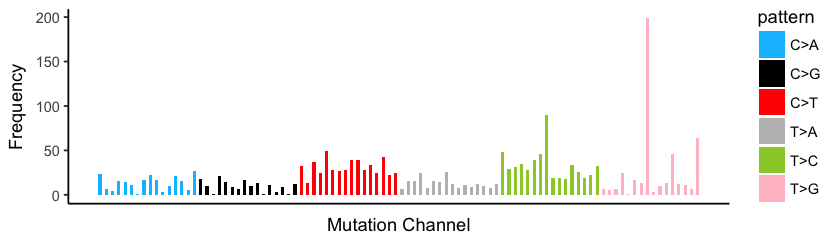

In [8]:
## the simulated_samples here are actually contain 6 signatures:
## the simulated samples contained the 100 samples we simulated, for each sample, there are 96-channels;
simulated_samples<-matrix(simulated_samples,ncol=100)
head(simulated_samples)
dim(simulated_samples)

## An example to show the 96-channels of the fisrt simulated sample; there are 100 in total.
simulation_plot(simulated_samples[,1])

## Double check how many activities the simulated samples actually have:
print ("Simulated_activities in example samples")
simulated_sig_activities[[1]]

print ("Simulated_activities contributions in example samples")
simulated_sig_contribution[[1]]


activities<-NULL
for (i in 1:100){
    activities<-c(activities,simulated_sig_activities[[i]])
}
uniq_activities<-unique(activities)
print ("Toal activities have been used for the simulation dataset:")
uniq_activities

#### Problem 1b: 
Try to infer the signatures back from the simulated data. Note you also need to somehow decide how many signatures are active. To do this make a model prediction of the counts and compare using different metrics against the input data. Note over fitting, i.e., using too many signatures is likely a problem. Read for instance from ["Alexandrov LB, et al. (2013) Deciphering Signatures of Mutational Processes Operative in Human Cancer. Cell Reports 2013](https://www.sciencedirect.com/science/article/pii/S2211124712004330) how to call the number of signatures needed to explain the input data. 


#### For problem 1b: I will use the simulated dataset to explore which is good for the model selection; Second, I will try to use three different simulated datasets to test the robustness the criteria and to form the final code module for the modle selection which will be used in problem 2.

#### Code mudule -- calculate the cosine similarity of two given signatures

In [9]:
## Calculate cosine similarity between two vectors.
cosine_similarity<-function(vectorA,vectorB){
    sum_AxB<-0
    sum_A2<-0
    sum_B2<-0
    
    value_numA<-length(vectorA[,1])
    value_numB<-length(vectorB[,1])
    if(value_numA==value_numB){
        for(i in 1:value_numA){
            sum_AxB<-sum_AxB+vectorA[i,1]*vectorB[i,1]
            sum_A2<-sum_A2+vectorA[i,1]*vectorA[i,1]
            sum_B2<-sum_B2+vectorB[i,1]*vectorB[i,1]
        }
    }
    sum_AxB/(sqrt(sum_A2)*sqrt(sum_B2))
}

#### Code module -- calculate the euclidian distance for reconstruction error

In [11]:
## Calculate euclidian distance for reconstruction error:
Euclidian_distance<-function(vectorA,vectorB){
    sum_A_B_2<-0

    value_numA<-length(vectorA[,1])
    value_numB<-length(vectorB[,1])
    if(value_numA==value_numB){
        for(i in 1:value_numA){
            sum_A_B_2<-sum_A_B_2+(vectorA[i,1]-vectorB[i,1])**2
        }
    }
    sqrt(sum_A_B_2)
}

#### Now, we have the simulated dataset. We know the real signatures for our datasets are 6. But, we would like to explore the model selection criteria for the identification.

### I: Reconstrunction errors for the different signature numbers N { N=range(2:9) }.

#### Code module -- to calculate reconstrucion error for given samples and activity number; which will be repeated for a certian number to avoid any instability of NMF itself

In [407]:
## Take simulated samples and different models (activity_number). Then run NMF -> check the reconstruction errors.

reconst_error<-function(samples,activity_num,repeat_nmf,seed){
    size<-dim(samples)[2]
    errors<-matrix(replicate(repeat_nmf,0),ncol=1)
    
    ## here we repeat the NMF deconvolution for 100 times. it is good to know the variance between the results
    
    for (i in 1:repeat_nmf){
        set.seed(repeat_nmf)
        NMF_sig<-nmf(samples,activity_num)
        signatures_W <- NMF_sig@fit@W
       
        contribution_H <- NMF_sig@fit@H
        reconstruct_M<-signatures_W %*% contribution_H
        
        reconstruct_error<-0
        
        for (j in 1:size){
            orignal_sample<-as.matrix(samples[,j])
            reconstruct_sample<-as.matrix(reconstruct_M[,j])
    
            error<-Euclidian_distance(orignal_sample,reconstruct_sample)
            reconstruct_error<-reconstruct_error+error
        }
        errors[i,1]<-reconstruct_error    
    }
    errors
}

#### Calling reconstruction error for all modles [2:9]

In [42]:
## Here, we will get the reconstruction errors from the activity number from 2 to 9:
## The operating dataset is 6-sig-dataset.
## This step is time-consuming:

errors<-matrix(replicate(size*8,0),ncol=8) ## size==100, 8==length(2:9) 
j<-0
for (i in 2:9){
    activity_num<-i
    j<-j+1
    errors[,j]<-reconst_error(simulated_samples,activity_num,50,i)
}

#### Print the error matrix collected for different models; Calculate the error decreased level from upstream-model to current-model.

In [43]:
colnames(errors)<-paste("N=",2:9,sep="")
head (errors)
dim(errors)
median_cons_errors<-apply(errors,2,median)
name_de<-NULL
decreased_error<-NULL
for (i in 2:8){
    lable<-paste(names(median_cons_errors)[i-1],names(median_cons_errors)[i],sep="->")
    decreased<-(median_cons_errors[i-1]-median_cons_errors[i])/median_cons_errors[i-1]
    name_de<-c(name_de,lable)
    decreased_error<-c(decreased_error,decreased)
}
names(decreased_error)<-name_de
decreased_error

N=2,N=3,N=4,N=5,N=6,N=7,N=8,N=9
6918.013,5136.290,2752.310,2132.428,1993.835,1977.911,1928.626,1896.160
6783.140,5106.235,2752.626,2138.733,1996.697,1960.297,1911.661,1889.003
6783.764,5108.931,2751.059,2139.338,1991.114,1955.733,1939.216,1891.776
6918.013,5122.859,2752.615,2132.149,1999.331,1974.680,1934.133,1908.133
6918.012,5137.725,2751.377,2135.612,1995.548,1954.217,1904.734,1888.640
6783.834,5108.283,2751.393,2146.323,1992.797,1950.797,1931.411,1879.440


[1] 100   8

N=2->N=3   N=3->N=4   N=4->N=5   N=5->N=6   N=6->N=7   N=7->N=8   N=8->N=9 
0.24655748 0.46169399 0.22295237 0.06738558 0.01661744 0.01737506 0.01514511

#### Re-arrange the error matrix for box-plot; Print the decreased error level again

[1] "The decreased reconstruction error with the increasing signature number (% of total error under current model):"
  N=2->N=3   N=3->N=4   N=4->N=5   N=5->N=6   N=6->N=7   N=7->N=8   N=8->N=9 
0.32724126 0.85767942 0.28692240 0.07225450 0.01689825 0.01768229 0.01537801 


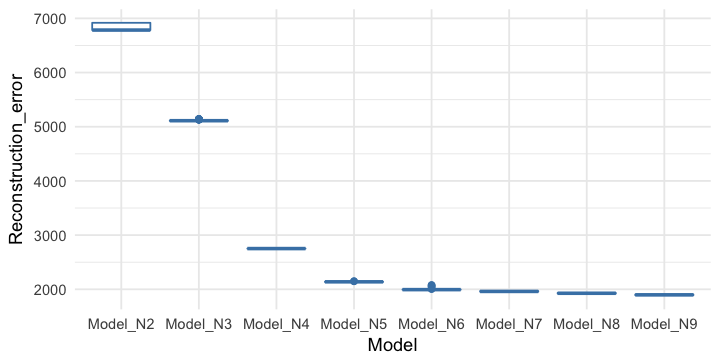

In [15]:
## This part will produce the box plot of reconstruction errors in different models:
## And the indvidual histgram plot of reconstruction error for each model:

lables<-paste("Model_N",2:9,sep="")

com_lables<-NULL
com_errors<-NULL

for (i in 1:length(lables)){
    com_lables<-c(com_lables,replicate(100,lables[i]))
    com_errors<-c(com_errors,errors[,i])
}

reconstruction_errors<-data.frame(Model=as.factor(com_lables),Reconstruction_error=as.numeric(com_errors))

options(repr.plot.width=6, repr.plot.height=3)
plot_box<-ggplot(reconstruction_errors, aes(x = Model, y = Reconstruction_error)) + geom_boxplot(col="steelblue")+theme_minimal()
plot_box

median_cons_errors<-apply(errors,2,median)
name_de<-NULL
decreased_error<-NULL
for (i in 2:8){
    lable<-paste(names(median_cons_errors)[i-1],names(median_cons_errors)[i],sep="->")
    decreased<-(median_cons_errors[i-1]-median_cons_errors[i])/median_cons_errors[i]
    name_de<-c(name_de,lable)
    decreased_error<-c(decreased_error,decreased)
}
names(decreased_error)<-name_de
print ("The decreased reconstruction error with the increasing signature number (% of total error under current model):")
print(decreased_error)


#### Comment

Here, we can see the reconstruction errors shrinked quickly from N=2 to N=6; But it didn't change that much after. There is only 1.6% reconstruct error decrease from N=6 to N=7 which remained until our last trial N=9. Therefore, I used a decrease indicator to describe how big this reconstruction error could be. One hypothesis could be the reconstruction error will be keep decreasing when the model is still looking for the right signature number. But once it reached the correct model, the error decrease level seemed very steady which probably caused by overfiting. Thus, this indicator could be used as model selection. We will use 5% of decrease level as the minimum error decrease level with the trade off model number incrasing.


### II. The reproductivity of the inferred signatures

#### Since the mutational processes has been defined as universal processes caused by the certain factors, it means that the more reproducible a signature is, the higher possibility that it has a biological meaning.

#### Thus, next we are going to check the reproductivity of the inferred signatuers from the the simulated samples. First, we will use monte carlo bootstrap to re-sample the given dataset to test the robust. The inferred signatures will be clustered together and the average silhouette width of the cluster will be used to estimate the godness of the cluster.

#### Code module -- resample the dataset and output the inferred signatures and contribution matrix for the cluster

In [271]:
## For the given activity number and bootstrap iteration:
## it will collect the inferred signatures and contribution from each resampled dataset

resample_and_sig_infer<-function(activity_num,n_bs,samples,seed){  ##n_bs: num of bootstrap   
    set.seed(seed)
    n_col<-dim(samples)[2] ## how many original samples
    
    ## for each dataset, the dim of signature matrix will be 96 X activity_num. For n_bs datasets, it will time n_bs
    sig<-matrix(replicate(activity_num*n_bs*96,0),nrow=96)
    
    ## for each dataset, the dim of contribution matrix will be activity_num X n_col. For n_bs datasets, times n_bs
    cont<-matrix(replicate(n_bs*n_col*activity_num,0),ncol=n_col) 

    for (bs in 1:n_bs){
               
        set.seed(bs)
        bs_data<-samples[,sample(n_col,size=n_col,replace=T)]
        non_zero<-sum(apply(bs_data,1,sum)==0)
#        print (non_zero)
        if(non_zero>1){ ## it has been added because if the whole row of all sample sum up to 0, errors occur in NMF
            for (seed in 100:200){
                set.seed(seed)
                bs_data<-samples[,sample(n_col,size=n_col,replace=T)]
                non_zero<-sum(apply(bs_data,1,sum)==0)
                if (non_zero==0) break
            }            
        }    
        
            
        NMF_sig<-nmf(bs_data,activity_num)
    
        start<-(bs-1)*activity_num+1 ## to calculate the column number to put the inferred signatures, row number is 96
        end<-bs*activity_num ## to calculate the row number to put inferred contribution, column number is n_col(100)
    
        sig[,start:end]<-NMF_sig@fit@W
        cont[start:end,]<-NMF_sig@fit@H
    }
    
    list(sig,cont) ## given the model, we have the inferred signatures and the corresponding contribution as the output
}

#### Code Module -- Calculate the cosine similarity between two given signatures

In [17]:
cosine_dist_matrix<-function(sig){
    length_sig<-dim(sig)[2]
    distance<-matrix(replicate(length_sig*length_sig,0),ncol=length_sig)

    for(i in 1: (dim(sig)[2])){    
        sig1<-as.matrix(sig[,i])
        for (j in 1:dim(sig)[2]){
            sig2<-as.matrix(sig[,j])        
            distance[i,j]<-1-cosine_similarity(sig1,sig2)
        }
    }
    as.dist(distance)   
}

#### Code module -- Cluster the inferred signatures and output the silhouette  width, group assignment for the cluster 

In [18]:
## The following will perform hierarchical cluster of the given inferred signatures based on the given number of sig.
## Then, it will give the average silhouette width of the cluster result.

## The larger average silhouette width means better cluster result,
## which furthermore means better reproductivity of the inferred signatures.
silhouette_width_of_inferred_sig<-function(dataset,num_sig){
    set.seed(12345)
    data<-as.matrix(dataset)
    number_sig<-dim(data)[2]
    
    dis_matrix<-matrix(replicate(number_sig*number_sig,0),ncol=number_sig) ## creat distance matrix    
    
    ## Fill up distance matrix for two given signatures. There are three methods could be applied (cosine,euclidian,KL)
    
    for (i in 1:number_sig){ ## fisrt loop
        pred_sig<-as.matrix(data[,i])
        for (j in 1:number_sig){ ## second loop
            picked_sig<-as.matrix(data[,j])
            dis_matrix[i,j]<-cosine_similarity(pred_sig,picked_sig)              
        }
    }
    
    ## assign sig names:
    colnames(dis_matrix)<-NULL
    rownames(dis_matrix)<-NULL
    #print(dis_matrix)    
    
    ## make dist matrix for headmap, here we use consine-similarity matrix, larger number means closer relationship.
    dis_matrix_copy<-as.matrix(dis_matrix)    
    dis_matrix<- as.dist(as.matrix(dis_matrix))
    
    ## for the tree cut method hclust and cutree, we are using 1-dis_matrix because the distance matrix used here
    ## should be used to describe the distance. it means larger value and larger distance. So we used 1-dis_matrix.
    hr <- hclust(1-dis_matrix, method="complete")
    ct<-cutree(hr, k=num_sig)
  
    sil<-silhouette(ct,1-dis_matrix) ## consine similarity distance matrix
#    mean_sil<-mean(sil[,3])    
    list(sil[,3],dis_matrix_copy,sil,ct)  
}

#### Resample the simulated dataset and get the whole inferred signature set for clustering

In [19]:
## time consuming:
m6_bs100<-resample_and_sig_infer(6,50,simulated_samples,1234) ## 123 is for setting seed

#### Cluster the inferred signatures; plot the cluster result; print the average silhouette width; plot the silhouette width in group assignments 

[1] "The average silhouette width of six sig inferred from the simulated dataset:"
[2] "0.896707446486106"                                                           


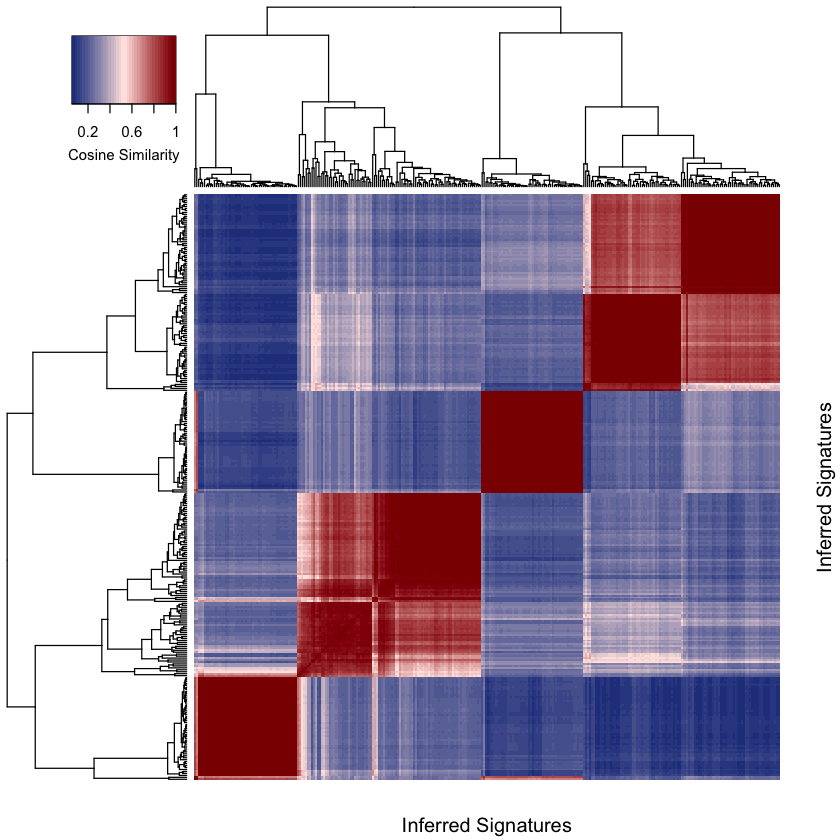

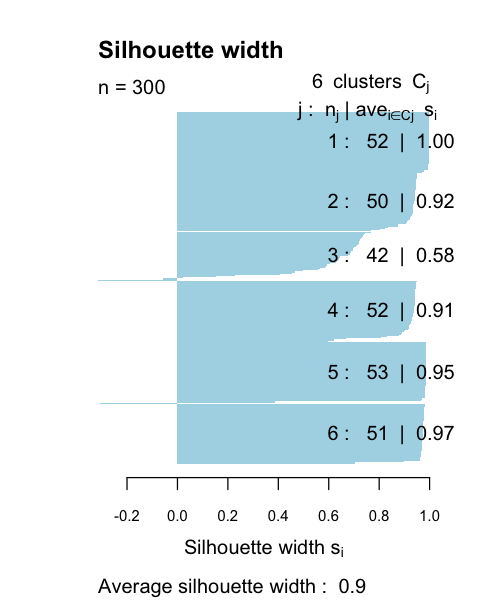

In [20]:
inferred_sig_6<-silhouette_width_of_inferred_sig(m6_bs100[[1]],6)
print (c("The average silhouette width of six sig inferred from the simulated dataset:",mean(inferred_sig_6[[1]])))

##we plotted the cluster result as fellows:

## heatmap plotting:
options(repr.plot.width=7, repr.plot.height=7)
mycol <- colorpanel(40, "royalblue4","mistyrose","red4")
heatmap.2(inferred_sig_6[[2]], col=mycol,scale="none",density.info="none",key.xlab="Cosine Similarity",
                    trace="none",margins = c(3,3),key.title="",keysize = 1.2,xlab = "Inferred Signatures", 
                    ylab = "Inferred Signatures",labRow = FALSE, labCol = FALSE)

## silhouette width plotting:
options(repr.plot.width=4, repr.plot.height=5)
plot(inferred_sig_6[[3]],col="lightblue",main="Silhouette width",cex.lab=1, cex.axis=0.75)

#### Comment:

##### We resampled the original 100 sample we simulated into 50 datasets. Then for each of the dataset, we called NMF to deconstruct it into 6 signatures. Here we plotted the cluster result of all the inferred signatures from the 50 bootstraped datasets. There are six clusters what we can see from the above heatmap, and the total average sihouette width of the 6 clusters is 0.9, which is good. However, there are two groups of signatures are not that easy to distinguish. Therefore, we would like to know more about if the inferred signatures could be aligned back to those we used for simulations.

#### Code module -- Calculate the cosine similarity of the given signatures and plot the heatmap of the cluster 

In [455]:
simlarity_sig<-function(dataset,width,height,margin1,margin2,flag="N"){
    data<-as.matrix(dataset)
    number_sig<-dim(data)[2]
    dis_matrix<-matrix(replicate(number_sig*number_sig,0),ncol=number_sig)
    colnames(dis_matrix)<-colnames(dataset)
    rownames(dis_matrix)<-colnames(dataset)
    ## calculate the cosine matrix
    for (i in 1:number_sig){
        pred_sig<-as.matrix(data[,i])
        for (j in 1:number_sig){
            picked_sig<-as.matrix(data[,j])           
            dis_matrix[i,j]<-cosine_similarity(pred_sig,picked_sig)
            if (i<j && dis_matrix[i,j]>0.9 && sum(grep("isig",rownames(dis_matrix)[i]))==1){
                print (c(rownames(dis_matrix)[i],colnames(dis_matrix)[j],dis_matrix[i,j]))
            }
        }
    }
    colnames(dis_matrix)<-colnames(dataset)
    rownames(dis_matrix)<-colnames(dataset)

    dis_matrix_copy<-as.matrix(dis_matrix)
#    print(dis_matrix_copy)
    dis_matrix<- as.dist(as.matrix(dis_matrix))
    options(repr.plot.width=width, repr.plot.height=height)
    mycol <- colorpanel(40, "royalblue4","mistyrose","red4")
#    print (dis_matrix)
    if (flag=="Y"){
        heatmap.2(dis_matrix_copy, col=mycol,scale="none", density.info="none",key.xlab="Cosine Similarity", 
              trace="none",margins = c(margin1,margin2),key.title="",keysize = 1.2)
   } 
}

#### Extract the mean signature from each cluster to form the final inferred signatures. Print the simulated and inferred signatures to see if the simulated ones could be found out

[1] "The dim of each inferred signature for module=6:"
[1] 96 52
[1] 96 50
[1] 96 42
[1] 96 52
[1] 96 53
[1] 96 51


isig_1,isig_2,isig_3,isig_4,isig_5,isig_6
0.0004989548,0.002164672,0.014983375,0.016277335,0.001365325,0.012856851
0.0018640275,0.002643784,0.008350554,0.009822062,0.001132581,0.009503523


[1] 1

sig_1,sig_5,sig_6,sig_10,sig_16,sig_17
0.011098326,0.014941548,0.0017,7e-04,0.0161,0.0018320192
0.009149341,0.008960918,0.0028,1e-03,0.0097,0.0003422356


[1] "sig_5"             "sig_16"            "0.903713558767296"
[1] "isig_1"            "sig_10"            "0.999509855864262"
[1] "isig_2"            "sig_6"             "0.997562084265298"
[1] "isig_3"            "sig_5"             "0.970245358710567"
[1] "isig_4"            "sig_16"            "0.990193879309957"
[1] "isig_5"            "sig_17"            "0.999025681779107"
[1] "isig_6"            "sig_1"             "0.997176813413078"
[1] "sig_5"             "sig_16"            "0.903713558767296"


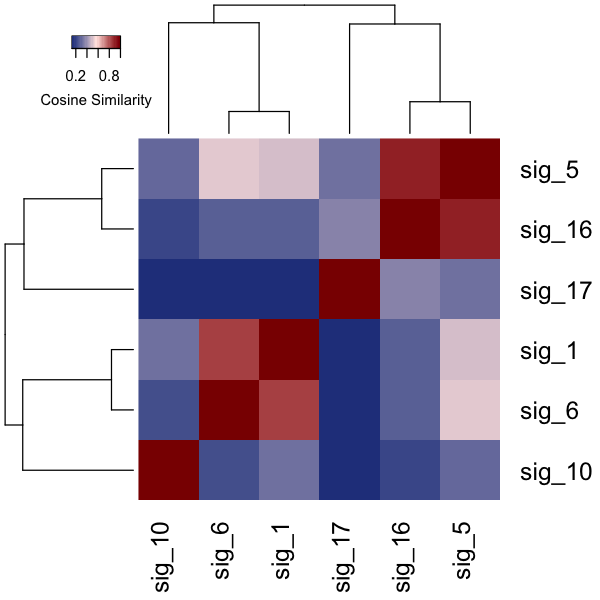

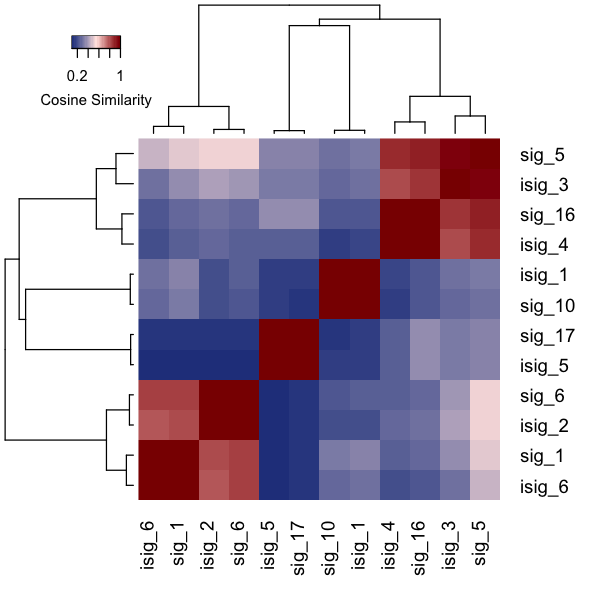

In [35]:
## the inferred signatures:
sig_matrix<-matrix(replicate(96*6,0),ncol=6)

#inferred_sig_6[[4]]
print("The dim of each inferred signature for module=6:")
for (i in 1:6){
    sig<-m6_bs100[[1]][,inferred_sig_6[[4]]==i]
    print (dim(sig))
    sum_sig<-apply(sig,2,sum)
    normarlise_sig<-apply(sig,1,function(x) x/sum_sig)
    normarlise_sig<-t(normarlise_sig)
    
    sig_matrix[,i]<-as.vector(apply(normarlise_sig,1,mean))
}

sig_id<-paste("isig",1:6,sep="_")
colnames(sig_matrix)<-sig_id
head(sig_matrix,2)
sum(sig_matrix[,1])
                          
## the known cosmic signatures:
known_cosmic6Sig<-cosmic30[c(1,5,6,10,16,17),]
known_cosmic6Sig_bycol<-t(known_cosmic6Sig)
colnames(known_cosmic6Sig_bycol)<-paste("sig",rownames(known_cosmic6Sig),sep="_")
rownames(known_cosmic6Sig_bycol)<-NULL
head(known_cosmic6Sig_bycol,2)
simlarity_sig(known_cosmic6Sig_bycol,5,5,5,5)
mix<-cbind(sig_matrix,known_cosmic6Sig_bycol)
simlarity_sig(mix,5,5,5,5)

#### Comment

##### From the above two figures, we learnt that, among the six signatures we used for simulation, sig5 and sig16 shared 0.9 consine similarity which probably is the reason caused the blur cluster reslut of those two inferred signatures.

##### From the output and cluster result, we could say the simulated signatures (sig 1/5/6/10/16/17) are successfuly identified by our method (isig_1/2/3/4/5/6), and they are almost identical to each other (cosine similarities are nearly 1).

#### Now, the problem is if average silhoette width could be used for model selection. The following test will help to find out the anwser. 

In [49]:
## Time consuming:

average_sil<-NULL ## second decider of which model will be choosen;

for (i in 2:9){
    activity_num<-i    
    ## from the reproductivity side:
    resampled_dataset<-resample_and_sig_infer(activity_num,50,simulated_samples,i*123) ## 50 is for bootstrap; i is for setting seed
#   print(dim(resampled_dataset[[1]]))        
    inferred_sig<-silhouette_width_of_inferred_sig(resampled_dataset[[1]],activity_num)
    average_sil<-c(average_sil,mean(inferred_sig[[1]]))
}

module,median_error,average_silhouette_width,improved_reconstruction
N=2,6783.823,0.7028973,1.00000000
N=3,5111.220,0.5611853,0.24655748
N=4,2751.401,0.9960386,0.46169399
N=5,2137.969,0.9601136,0.22295237
N=6,1993.901,0.9075972,0.06738558
N=7,1960.767,0.7755917,0.01661744
N=8,1926.699,0.7018466,0.01737506
N=9,1897.519,0.5906823,0.01514511


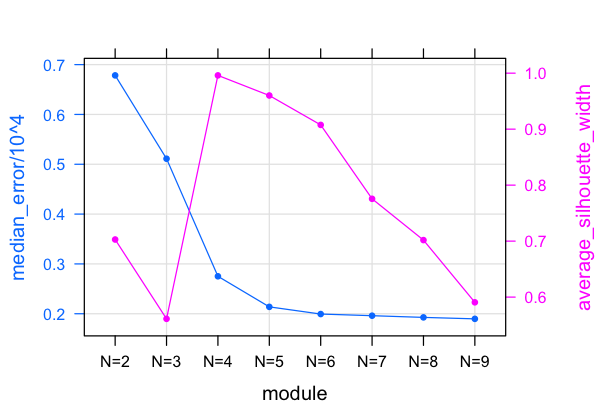

In [58]:
## Together with the construction error, we get the table below for our model selection plot
estimation<-data.frame(module=names(median_cons_errors),median_error=as.vector(unname(median_cons_errors)),
           average_silhouette_width=average_sil,improved_reconstruction=c(1,unname(decreased_error)))

estimation

estimation$module<-factor(estimation$module,levels=as.factor(estimation$module))
options(repr.plot.width=5, repr.plot.height=3.5)

    obj1 <- xyplot(median_error/10**4 ~ module, estimation, type = c("p", "l"), lwd=1,pch=20,grid = TRUE)
    obj2 <- xyplot(average_silhouette_width ~ module, estimation, type = c("p", "l"), pch=20,lwd=1)
    plot<-doubleYScale(obj1, obj2, add.ylab2 = TRUE)
plot

#### Comment

##### As we could see from the above plot, the mean reconstruction error is dropped from N=2 and mantained the decrease level (1.6%) since number of N/sig is from 7 to 9. Based the part I experiment, we decided to choose 5% as our mininum decrease level. Thus the reconstruction error tells us the correct model is 6.

##### However, the highest average silhoette width implies 4 is the correct signature based on the reproductivity, which is different with another criteria.

##### From our above analysis, we noticed that sig1-sig6, sig5-sig16 both signature pairs are very similar, which might disturbed the cluster result. Therefore, we will go explore further if the high similarities between simulation signatures will affect the model selection and which criteria can be more reliable for the final decision.


### Part III The combination of two selection model selection criteria; Form to the final code for part 2

#### Code module -- it will select model for the given dataset and output the inferred signatures decided by the relatively low reconstruction error and high reproductivity.

In [399]:
Module_estimation<-function(dataset,module_range=2:9){## the column of the dataset represents the sample number
    ## size is the sample size in the whole spectrum;
    size<-dim(dataset)[2]
    nmf_repeat<-30
    ## errors will collect the NMF reconstruction errors from the median error of the repeated NMF running results;
    ## the default repeat times is 30:
    errors<-matrix(replicate(nmf_repeat*length(module_range),0),ncol=length(module_range)) ## size==100, 8==length(2:9) 
    
    average_sil<-NULL ## second decider of which model will be choosen;
    inferred_signature<-list() ## will record the mean signatures inferred for each model:
    
    j<-0 ## will record the error matrix columns from 1 and increase 1 step everytime.
    inferred_signature[[1]]<-NULL
    for (i in module_range){
#        print(i)
        ## from the reconstruction error side:
        activity_num<-i
        j<-j+1
        errors[,j]<-reconst_error(dataset,activity_num,nmf_repeat,i*123) ## i is for setting seed
        
        ## from the reproductivity side:
        resampled_dataset<-resample_and_sig_infer(activity_num,30,dataset,i*123) ## 50 is for bootstrap; i is for setting seed
#        print(dim(resampled_dataset[[1]]))
        
        inferred_sig<-silhouette_width_of_inferred_sig(resampled_dataset[[1]],activity_num)

#        print(inferred_sig[[4]])
        average_sil<-c(average_sil,mean(inferred_sig[[1]]))
#        print(mean(inferred_sig[[1]]))
        
        
        ## get the signature inferred for different models:
        sig_matrix<-matrix(replicate(96*i,0),ncol=i)
        
        for (sig_order in 1:i){
            sig<-resampled_dataset[[1]][,inferred_sig[[4]]==sig_order]
            
            if (sum(inferred_sig[[4]]==sig_order)>1){                
                sum_sig<-apply(sig,2,sum)
                normarlise_sig<-apply(sig,1,function(x) x/sum_sig)
                normarlise_sig<-t(normarlise_sig)
                sig_matrix[,sig_order]<-as.vector(apply(normarlise_sig,1,mean))
                    
            }else if(sum(inferred_sig[[4]]==sig_order)==1){
                sig_matrix[,sig_order]<-sig   
            }
        }
#        print(sig_matrix)
        sig_id<-paste("isig",1:i,sep="_")
        colnames(sig_matrix)<-sig_id     
        inferred_signature[[i]]<-sig_matrix
#        names(inferred_signature)[j]<-paste("N=",i,sep="")
    }
    
    ## re-name the error matrix and calcute the error decrease percentage;
    colnames(errors)<-paste("N=",module_range,sep="")
#    print(dim (errors))
    median_cons_errors<-apply(errors,2,median)
#    print (median_cons_errors)
#    return(inferred_signature)
    name_de<-NULL
    decreased_error<-1
    for (i in 2:length(module_range)){
        decreased<-(median_cons_errors[i-1]-median_cons_errors[i])/median_cons_errors[i-1]
        decreased_error<-c(decreased_error,decreased)
    }
    names(decreased_error)<-names(median_cons_errors)                        
#    print (decreased_error)
                                  
                                  
    ## Fisrt decider is based on reconstruction error. 
    ##I take the cut off value of 0.05 as the least decrease percent with increasing signature numbers:
    decider1<-as.vector(unname(decreased_error))
    names(decider1)<-names(median_cons_errors)
    decider1<-decider1[decider1>0.05]
    decider1_module<-names(decider1[decider1==min(decider1)])
    decider1_module_num<-as.numeric(unlist(strsplit(decider1_module,"="))[2])
#    print (decider1_module)
    
                                  
    ## The second decider is based on the reproductivity of the produced cluster;
    decider2<-as.vector(average_sil)
    names(decider2)<-names(median_cons_errors)
    decider2_module<-names(decider2[decider2==max(decider2)])
    decider2_module_num<-as.numeric(unlist(strsplit(decider2_module,"="))[2])
#    print (decider2_module)
    
                                 
    estimation<-data.frame(module=names(median_cons_errors),median_error=as.vector(unname(median_cons_errors)),
           average_silhouette=average_sil,improved_construction=decreased_error)
#    print (inferred_signature[[decider1_module_num]])
#    print (inferred_signature$decider2_module)                            
    rownames(estimation)<-NULL
                                      
    if (decider1_module_num==decider2_module_num){
        return(list(estimation,decider1_module_num,inferred_signature))
    }else{
#        return(list(estimation,decider1_module_num,inferred_signature[[decider1_module_num]],decider2_module_num,inferred_signature[[decider2_module_num]]))
        return(list(estimation,decider2_module_num,inferred_signature))
    }
    
}

#### Here, we removed the sig6 which is close to sig1. Instead, we will add sig2 which is not close to any of the other signatures based on the total cosine similarity matrix produced in Assignment 1. Thus, we only left one group of signature (sig5 and sig16) as we show below which are very similar. Based on the new simulated dataset, we will try the module estimation moduel again.

[1] "sig_5"             "sig_16"            "0.903713558767296"
            sig_1      sig_2      sig_5     sig_10     sig_16
sig_2  0.14060868                                            
sig_5  0.48756658 0.19954607                                 
sig_10 0.31693861 0.14160746 0.28838810                      
sig_16 0.27393897 0.22753183 0.90371356 0.21380621           
sig_17 0.13187529 0.09600492 0.32654085 0.14344379 0.35097971


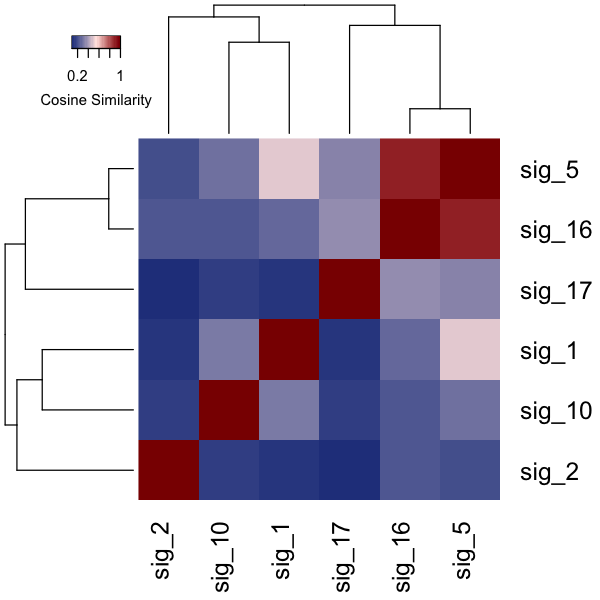

In [62]:
## Simulate a dataset to infer signatures:
## The aim to produce this simulated data is going to infer 

known_cosmic6Sig<-cosmic30[c(1,2,5,10,16,17),] ## the signatures picked by interest

known_cosmic6Sig_bycol<-t(known_cosmic6Sig)
colnames(known_cosmic6Sig_bycol)<-paste("sig",rownames(known_cosmic6Sig),sep="_")
rownames(known_cosmic6Sig_bycol)<-NULL
simlarity_sig(known_cosmic6Sig_bycol,5,5,5,5)

average_processes<-4
somatic_num_wgs<-2000
size<-100    ## Produce 100 simulated samples. 
model<-"poisson"

## lists to put all the simulated samples together:
simulated_samples<-NULL
simulated_sig_activities<-list()
simulated_sig_contribution<-list()

##### Call simulation functions
for (i in 1:size){
    simulated_output<-simulate_mutational_process(average_processes,somatic_num_wgs,known_cosmic6Sig,model,i)
    simulated_samples<-c(simulated_samples,simulated_output[[1]])
#    simulated_samples[1:96,i]<-matrix(simulated_output[[1]])
    simulated_sig_activities[[i]]<-simulated_output[[2]]
    simulated_sig_contribution[[i]]<-simulated_output[[3]]
}
simulated_samples<-matrix(simulated_samples,ncol=size)

In [65]:
## time consuming:
simulated_module_selection_1<-Module_estimation(simulated_samples,2:10)

In [67]:
simulated_module_selection_1[[1]]

module,median_error,average_silhouette,improved_construction
N=2,8519.102,0.7228282,1.00000000
N=3,6516.633,0.6933012,0.23505638
N=4,4562.659,0.8365016,0.29984411
N=5,2005.293,0.9959119,0.56049892
N=6,1901.549,0.9142412,0.05173523
N=7,1874.394,0.8475646,0.01428062
N=8,1847.834,0.7521086,0.01416964
N=9,1821.243,0.6622754,0.01439078
N=10,1794.434,0.6757616,0.01472000


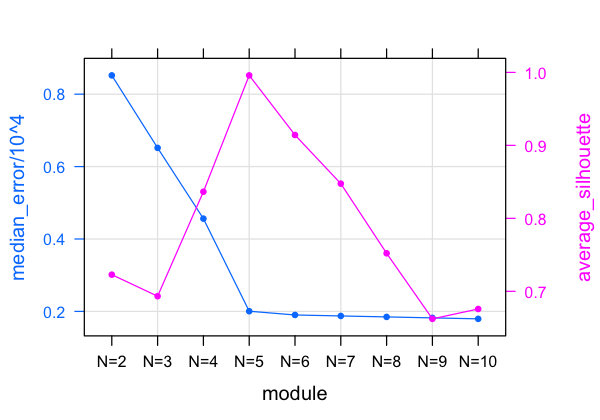

In [68]:
estimation<-simulated_module_selection_1[[1]]
estimation$module<-factor(estimation$module,levels=as.factor(estimation$module))
options(repr.plot.width=5, repr.plot.height=3.5)

    obj1 <- xyplot(median_error/10**4 ~ module, estimation, type = c("p", "l"), lwd=1,pch=20,grid = TRUE)
    obj2 <- xyplot(average_silhouette ~ module, estimation, type = c("p", "l"), pch=20,lwd=1)
    plot<-doubleYScale(obj1, obj2, add.ylab2 = TRUE)
plot

#### Comment

##### If we remain one similar pair of signatures in our simulation, we found that the model selection results from average sihoette width (N=5) and that from re-construction error (N=6) are different as well. Again, the decreased re-construction error shows consistent model selection result with our simulation data. 

##### Next, we will use signatures have low similarity for the simulation to check if the two criteria will be able to found out the read signature number.

            sig_1      sig_2      sig_5     sig_10     sig_17
sig_2  0.14060868                                            
sig_5  0.48756658 0.19954607                                 
sig_10 0.31693861 0.14160746 0.28838810                      
sig_17 0.13187529 0.09600492 0.32654085 0.14344379           
sig_18 0.22433413 0.10630974 0.41959399 0.48845927 0.07553887


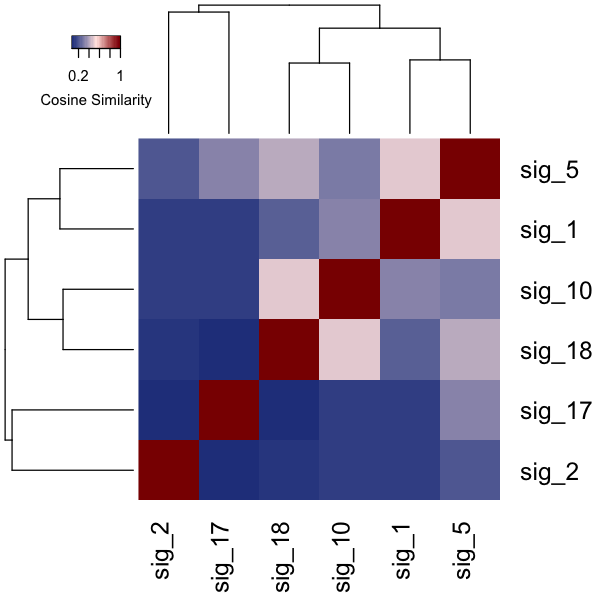

In [75]:
## Simulate a dataset to infer signatures:
## The aim to produce this simulated data is going to infer 

known_cosmic6Sig<-cosmic30[c(1,2,5,10,17,18),] ## the signatures picked by interest
known_cosmic6Sig_bycol<-t(known_cosmic6Sig)
colnames(known_cosmic6Sig_bycol)<-paste("sig",rownames(known_cosmic6Sig),sep="_")
rownames(known_cosmic6Sig_bycol)<-NULL
simlarity_sig(known_cosmic6Sig_bycol,5,5,5,5)

average_processes<-4
somatic_num_wgs<-2000
size<-100    ## Produce 100 simulated samples. 
model<-"poisson"

## lists to put all the simulated samples together:
simulated_samples<-NULL
simulated_sig_activities<-list()
simulated_sig_contribution<-list()

##### Call simulation functions
for (i in 1:size){
    simulated_output<-simulate_mutational_process(average_processes,somatic_num_wgs,known_cosmic6Sig,model,i)
    simulated_samples<-c(simulated_samples,simulated_output[[1]])
#    simulated_samples[1:96,i]<-matrix(simulated_output[[1]])
    simulated_sig_activities[[i]]<-simulated_output[[2]]
    simulated_sig_contribution[[i]]<-simulated_output[[3]]
}
simulated_samples<-matrix(simulated_samples,ncol=size)

In [76]:
## time consuming:
simulated_module_selection_2<-Module_estimation(simulated_samples,2:10)

In [77]:
simulated_module_selection_2[[1]]

module,median_error,average_silhouette,improved_construction
N=2,9623.076,0.7892773,1.000000000
N=3,6802.043,0.9016317,0.293152894
N=4,4803.205,0.9778641,0.293858474
N=5,2871.627,0.9543322,0.402143530
N=6,1931.735,0.9914416,0.327303097
N=7,1910.965,0.8445874,0.010752052
N=8,1889.557,0.8434388,0.011202559
N=9,1862.315,0.7431100,0.014417052
N=10,1845.721,0.6974224,0.008910457


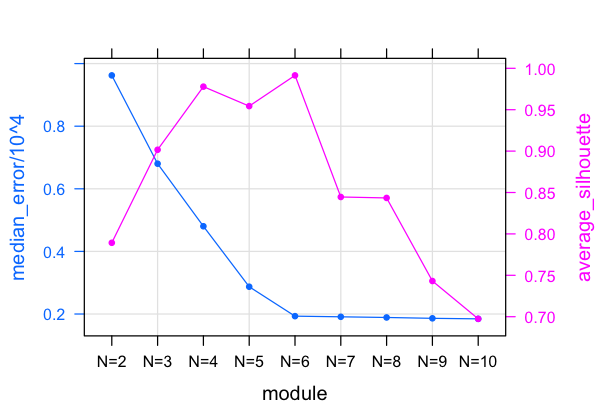

In [78]:
estimation<-simulated_module_selection_2[[1]]
estimation$module<-factor(estimation$module,levels=as.factor(estimation$module))
options(repr.plot.width=5, repr.plot.height=3.5)
    obj1 <- xyplot(median_error/10**4 ~ module, estimation, type = c("p", "l"), lwd=1,pch=20,grid = TRUE)
    obj2 <- xyplot(average_silhouette ~ module, estimation, type = c("p", "l"), pch=20,lwd=1)
    plot<-doubleYScale(obj1, obj2, add.ylab2 = TRUE)
plot
#abline( v = 5, col = "gray60")
#panel.abline(v=mean(module),data=estimation)

##### The above test result shows the two criteria has the same result (N=6). Therefore, the similarities between the real signatures will affect the model selction in the deconstruction, and the reduced reconstruction error (5%) is more roboust in the decision making.

### Problem 2: Inference with real data <a id='Problem1'></a>

#### Problem 2a: 
Use the real data set and perform signature extraction. Do this for one cancer type at a time. Map the resulting signatures onto the 30 given signatures. How many of them you can find if you call a match if cosine similarity is bigger than 0.9? 

Here is an example but again no inference on what would be a good number of signatures is done. 

In [167]:
somaticMutations$total<-apply(somaticMutations[,2:97],1,sum)
cancer_names<-somaticMutations$cancer_type
cancer_types<-unique(cancer_names)
length(cancer_types)
cancer_types

[1] 30

[1] ALL                  AML                  Bladder             
 [4] Breast               CLL                  Cervix              
 [7] Colorectum           Esophageal           Glioblastoma        
[10] GliomaLowGrade       HeadandNeck          KidneyChromophobe   
[13] KidneyClearCell      KidneyPapillary      Liver               
[16] LungAdeno            LungSmallCell        LungSquamous        
[19] LymphomaB-cell       Medulloblastoma      Melanoma            
[22] Myeloma              Neuroblastoma        Ovary               
[25] Pancreas             PilocyticAstrocytoma Prostate            
[28] Stomach              Thyroid              Uterus              
30 Levels: ALL AML Bladder Breast CLL Cervix Colorectum ... Uterus

#### I first tried to use data from all cancer types to infer the signatures. But the NMF has reported errors (e.g. "Error: NMF::nmf - Input matrix x contains at least one null or NA-filled row."). Considering the dataset given is the mixture of Exome and WGS data, combination of both data sources might induce the imblanced information on 96-channels for NMF(exome region is only 1% of the whole genome). Thus, I will use the mutational burden (1145) which I calculated in the fisrt assignment to distinguish WGS samples from exome data to extract the WGS data for the signature identification. Therefore, there might not be avaiable data for all cancer samples.

In [445]:
## if the mutation burden of a sample is over 1145 and the remaining samples for that cancer type is over 10.
## The signature inference will be carried on.
left_cancer_types<-NULL
wgs_somaticMutation<-NULL
for (cancer_type in cancer_types){
    
    dataset<-somaticMutations[somaticMutations$cancer_type==cancer_type,1:98]
#    dataset$total
    
#    cutoff<-sum(dataset$total)*0.01
    cutoff<-1145
    before<-length(dataset$total)
    index<-dataset$total>cutoff
    left<-sum(index)
    if (left>10){
        dataset1<-dataset[index,1:98]
        wgs_somaticMutation<-rbind(wgs_somaticMutation,dataset1)
        left_cancer_types<-c(left_cancer_types,cancer_type)
    }
}
head(left_cancer_types)

[1] "Breast"         "CLL"            "Colorectum"     "Liver"         
[5] "LungAdeno"      "LymphomaB-cell"

In [559]:
all_iSig<-NULL

### Breast

In [460]:
cancer_type<-left_cancer_types[1]
cancer_type
dataset<-as.matrix(wgs_somaticMutation[wgs_somaticMutation$cancer_type==cancer_type,2:97])
colnames(dataset)<-NULL
rownames(dataset)<-NULL
dataset<-t(dataset)
dim(dataset)
module_range<-2:13

[1] "Breast"

[1]  96 116

In [421]:
## Time consuming:
module_estimation_Breast<-Module_estimation(dataset,module_range)

module,median_error,average_silhouette,improved_construction
N=2,23747.528,0.9949746,1.00000000
N=3,18249.428,0.9809031,0.23152303
N=4,16450.468,0.6384935,0.09857627
N=5,14951.299,0.4592573,0.09113229
N=6,11386.571,0.5712824,0.23842261
N=7,10870.372,0.6711893,0.04533405
N=8,10313.659,0.5412879,0.05121380
N=9,9814.001,0.5906638,0.04844622
N=10,9199.279,0.5244873,0.06263727
N=11,8598.576,0.4610821,0.06529891


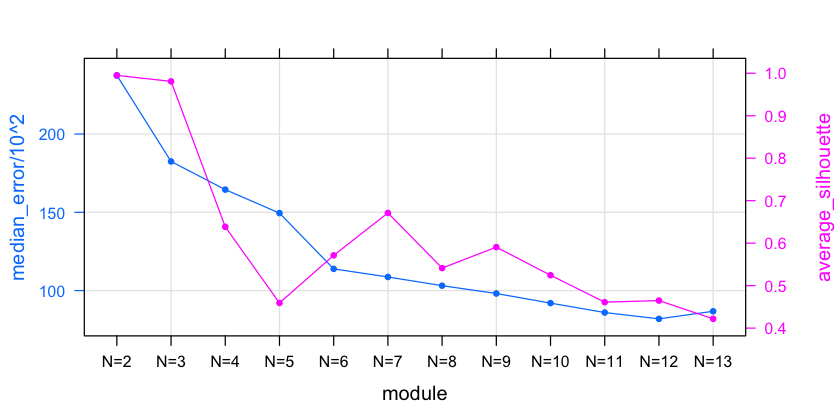

In [560]:
estimation<-module_estimation_Breast[[1]]
estimation$module<-factor(estimation$module,levels=as.factor(estimation$module))
options(repr.plot.width=7, repr.plot.height=3.5)
    obj1 <- xyplot(median_error/10**2 ~ module, estimation, type = c("p", "l"), lwd=1,pch=20,grid = TRUE)
    obj2 <- xyplot(average_silhouette ~ module, estimation, type = c("p", "l"), pch=20,lwd=1)
    plot<-doubleYScale(obj1, obj2, add.ylab2 = TRUE)
plot
estimation

##### From the above figure and table, we can find that the real data behaves differently with the simulated data. I tried to use the largest log value of median error and silhoette width. But it is not good for the model selection either. For the following cancer types,including breast cancer, I will give the model number based on my experience.


#### The N=7 is likely to be the correct signature number for breast cancer. I will check if any known signatures will be found out.

In [561]:
isig<-module_estimation_Breast[[3]]
correct_isig<-isig[[7]]

all_iSig<-cbind(all_iSig,correct_isig) ## to take all the signatures found in each cancer type

head(correct_isig,2)

known_cosmic<-cosmic30
known_cosmic_bycol<-t(known_cosmic)
colnames(known_cosmic_bycol)<-paste("sig",rownames(known_cosmic),sep="_")
rownames(known_cosmic_bycol)<-NULL

#simlarity_sig(known_cosmic_bycol,8,8,5,5)
mix<-cbind(correct_isig,known_cosmic_bycol)
print ("How many known signatures similar to isig:")
simlarity_sig(mix,5,5,5,5)

isig_1,isig_2,isig_3,isig_4,isig_5,isig_6,isig_7
0.003617144,0.03306991,0.003438375,0.05010626,0.01226459,0.002426267,0.04385857
0.004527757,0.01197963,0.001433250,0.02483712,0.01635556,0.009958667,0.02025810


[1] "How many known signatures similar to isig:"
[1] "isig_1"            "sig_13"            "0.993254322986607"
[1] "isig_3"            "sig_2"             "0.961637421035273"
[1] "isig_4"            "sig_8"             "0.915298900856184"
[1] "isig_5"           "sig_3"            "0.93902585612311"
[1] "isig_5"            "sig_5"             "0.913628050904645"
[1] "isig_6"            "sig_1"             "0.919040114322802"


[1] "isig_1"            "sig_13"            "0.993254322986607"
[1] "isig_3"            "sig_2"             "0.961637421035273"
[1] "isig_4"            "sig_8"             "0.915298900856184"
[1] "isig_5"           "sig_3"            "0.93902585612311"
[1] "isig_5"            "sig_5"             "0.913628050904645"
[1] "isig_6"            "sig_1"             "0.919040114322802"


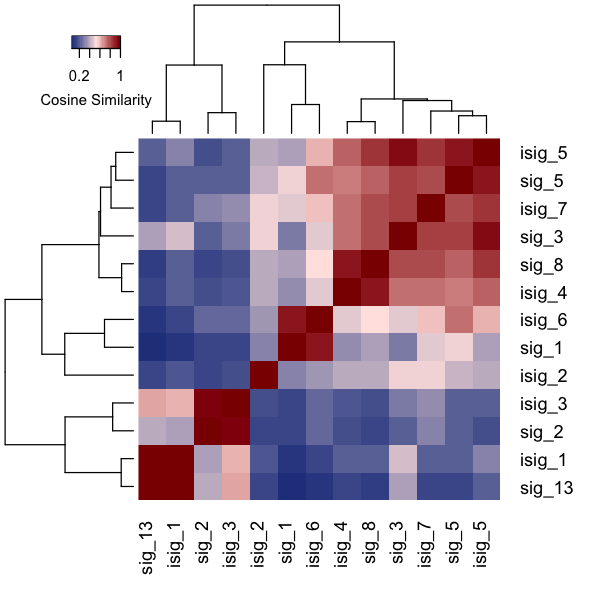

In [459]:
target_known_cosmic<-cosmic30[c(1,2,3,5,8,13),]
target_known_cosmic_bycol<-t(target_known_cosmic)
colnames(target_known_cosmic_bycol)<-paste("sig",rownames(target_known_cosmic),sep="_")
rownames(known_cosmic_bycol)<-NULL
mix<-cbind(correct_isig,target_known_cosmic_bycol)
simlarity_sig(mix,5,5,5,5,"Y")

#### Comment

##### There are 13 known signatures for breast cancer, e.g. sig 1/2/3/5/6/8/10/13/17/18/20/26/30. The isignatures we found here are 7 in total, and 6 out of 7 have been mapped back to the known signatures. The removal of samples probably has caused the missing signatures.

### CLL

In [411]:
cancer_type<-left_cancer_types[2]
dataset<-as.matrix(wgs_somaticMutation[wgs_somaticMutation$cancer_type==cancer_type,2:97])
colnames(dataset)<-NULL
rownames(dataset)<-NULL
dataset<-t(dataset)
dim(dataset)
module_range<-2:13

[1] 96 21

In [412]:
module_estimation_CLL<-Module_estimation(dataset,module_range)

module,median_error,average_silhouette,improved_construction
N=2,1276.2103,0.9351271,1.00000000
N=3,1056.2096,0.6192302,0.17238597
N=4,972.9511,0.5963529,0.07882759
N=5,918.7778,0.4161112,0.05567940
N=6,854.3581,0.3796685,0.07011451
N=7,778.2983,0.3224735,0.08902568
N=8,732.9975,0.2464315,0.05820490
N=9,674.6282,0.2318138,0.07963098
N=10,632.6326,0.2203840,0.06225008
N=11,574.4223,0.1658984,0.09201279


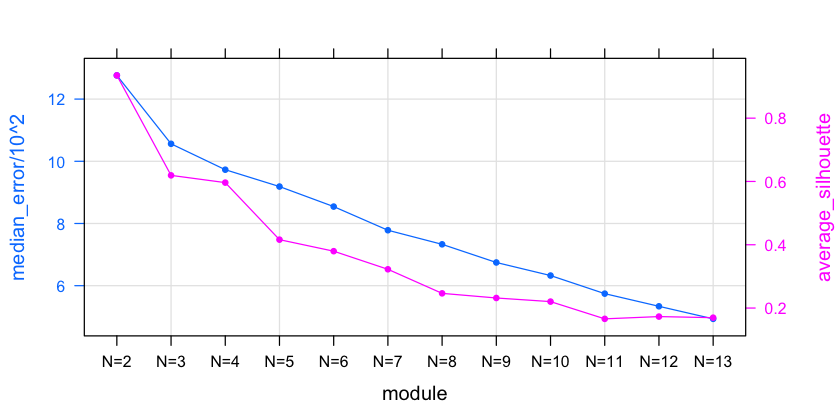

In [415]:
estimation<-module_estimation_CLL[[1]]
estimation$module<-factor(estimation$module,levels=as.factor(estimation$module))
options(repr.plot.width=7, repr.plot.height=3.5)
    obj1 <- xyplot(median_error/10**2 ~ module, estimation, type = c("p", "l"), lwd=1,pch=20,grid = TRUE)
    obj2 <- xyplot(average_silhouette ~ module, estimation, type = c("p", "l"), pch=20,lwd=1)
    plot<-doubleYScale(obj1, obj2, add.ylab2 = TRUE)
plot
estimation

#### The correct module I think here will be N=4;

In [562]:
isig<-module_estimation_CLL[[3]]
correct_isig<-isig[[4]]
all_iSig<-cbind(all_iSig,correct_isig) ## to take all the signatures found in each cancer type
head(correct_isig,2)

known_cosmic<-cosmic30
known_cosmic_bycol<-t(known_cosmic)
colnames(known_cosmic_bycol)<-paste("sig",rownames(known_cosmic),sep="_")
rownames(known_cosmic_bycol)<-NULL

#simlarity_sig(known_cosmic_bycol,8,8,5,5)
mix<-cbind(correct_isig,known_cosmic_bycol)
print ("How many known signatures similar to isig:")
simlarity_sig(mix,5,5,5,5)

isig_1,isig_2,isig_3,isig_4
0.016087568,0.01832009,0.008269084,0.03487842
0.007294883,0.01408525,0.006393766,0.01200891


[1] "How many known signatures similar to isig:"
[1] "isig_1"            "sig_9"             "0.955110062864274"
[1] "isig_2"           "sig_5"            "0.91377221708003"
[1] "isig_3"            "sig_9"             "0.909598171873316"


[1] "isig_1"            "sig_9"             "0.955110062864274"
[1] "isig_2"           "sig_5"            "0.91377221708003"
[1] "isig_3"            "sig_9"             "0.909598171873316"


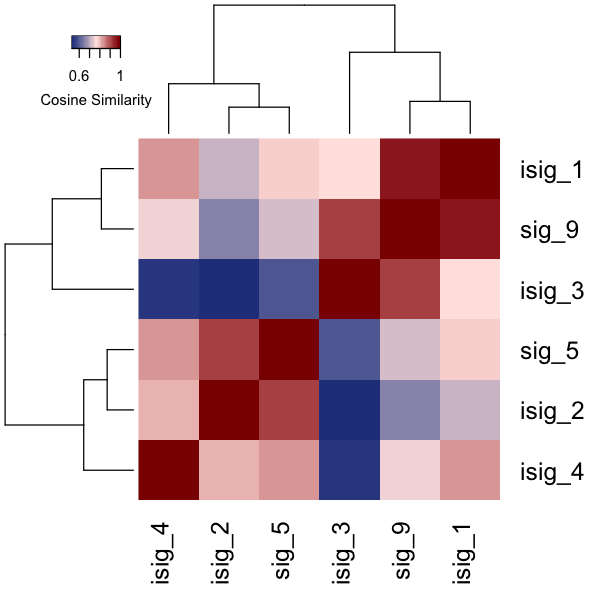

In [464]:
target_known_cosmic<-cosmic30[c(5,9),]
target_known_cosmic_bycol<-t(target_known_cosmic)
colnames(target_known_cosmic_bycol)<-paste("sig",rownames(target_known_cosmic),sep="_")
rownames(known_cosmic_bycol)<-NULL
mix<-cbind(correct_isig,target_known_cosmic_bycol)
simlarity_sig(mix,5,5,5,5,"Y")

#### There are 5 known signatures (1/2/5/9/13) for CLL, but we only found out sig 5 and sig9 out of our four signatuers. 

### Colorectum

In [416]:
cancer_type<-left_cancer_types[3]
dataset<-as.matrix(wgs_somaticMutation[wgs_somaticMutation$cancer_type==cancer_type,2:97])
colnames(dataset)<-NULL
rownames(dataset)<-NULL
dataset<-t(dataset)
dim(dataset)
module_range<-2:13

[1] 96 35

In [417]:
module_estimation_Colorectum<-Module_estimation(dataset,module_range)

module,median_error,average_silhouette,improved_construction
N=2,6957.712,0.9914150,1.00000000
N=3,6017.462,0.8164396,0.13513788
N=4,4878.074,0.6745067,0.18934697
N=5,3513.083,0.5963109,0.27982159
N=6,2978.796,0.5046571,0.15208486
N=7,2606.018,0.5194009,0.12514390
N=8,2342.533,0.4365594,0.10110652
N=9,2032.713,0.5237914,0.13225842
N=10,1883.658,0.3932516,0.07332795
N=11,1694.159,0.4155869,0.10060182


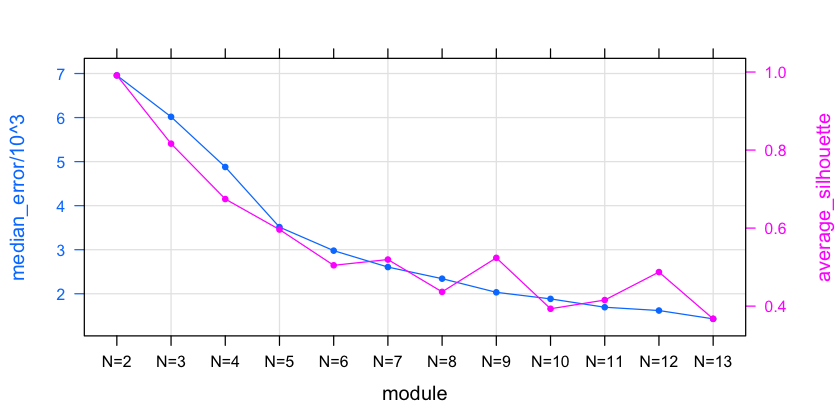

In [419]:
estimation<-module_estimation_Colorectum[[1]]
estimation$module<-factor(estimation$module,levels=as.factor(estimation$module))
options(repr.plot.width=7, repr.plot.height=3.5)
    obj1 <- xyplot(median_error/10**3 ~ module, estimation, type = c("p", "l"), lwd=1,pch=20,grid = TRUE)
    obj2 <- xyplot(average_silhouette ~ module, estimation, type = c("p", "l"), pch=20,lwd=1)
    plot<-doubleYScale(obj1, obj2, add.ylab2 = TRUE)
plot
estimation

#### Here, I will choose N=7 for the model

In [563]:
isig<-module_estimation_Colorectum[[3]]

correct_isig<-isig[[7]]
all_iSig<-cbind(all_iSig,correct_isig) ## to take all the signatures found in each cancer type
head(correct_isig,2)

known_cosmic<-cosmic30
known_cosmic_bycol<-t(known_cosmic)
colnames(known_cosmic_bycol)<-paste("sig",rownames(known_cosmic),sep="_")
rownames(known_cosmic_bycol)<-NULL

#simlarity_sig(known_cosmic_bycol,8,8,5,5)
mix<-cbind(correct_isig,known_cosmic_bycol)
print ("How many known signatures similar to isig:")
simlarity_sig(mix,5,5,5,5)

isig_1,isig_2,isig_3,isig_4,isig_5,isig_6,isig_7
0.002292755,0.001770353,0.001127369,0.001257623,0.001994985,0.0007183554,0.0016566395
0.002111471,0.003095855,0.001967586,0.002568055,0.001779880,0.0009334583,0.0006325638


[1] "How many known signatures similar to isig:"
[1] "isig_2"            "sig_15"            "0.963808894132409"
[1] "isig_3"            "sig_10"            "0.981185171445362"
[1] "isig_5"            "sig_1"             "0.900368971449288"
[1] "isig_5"            "sig_6"             "0.964222992074822"


[1] "isig_2"            "sig_15"            "0.963808894132409"
[1] "isig_3"            "sig_10"            "0.981185171445362"
[1] "isig_5"            "sig_1"             "0.900368971449288"
[1] "isig_5"            "sig_6"             "0.964222992074822"


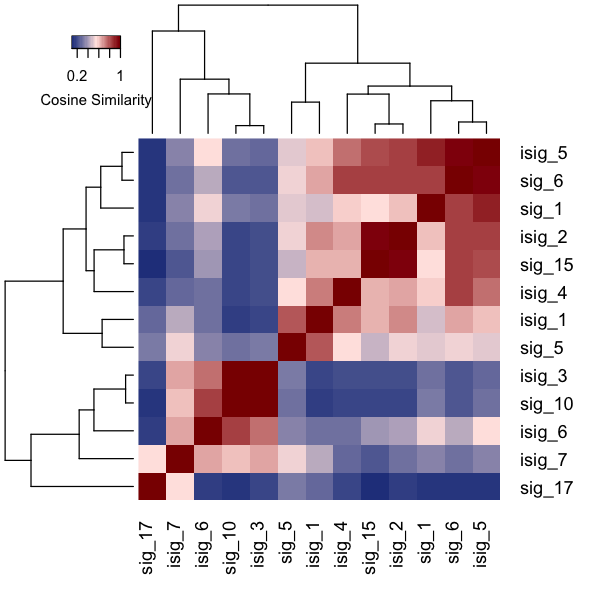

In [479]:
target_known_cosmic<-cosmic30[c(1,5,6,10,15,17),]
target_known_cosmic_bycol<-t(target_known_cosmic)
colnames(target_known_cosmic_bycol)<-paste("sig",rownames(target_known_cosmic),sep="_")
rownames(known_cosmic_bycol)<-NULL
mix<-cbind(correct_isig,target_known_cosmic_bycol)
simlarity_sig(mix,5,5,5,5,"Y")

#### Comment

##### The known colorectal cancer signatures are sig 1/5/6/10/15/17. Our isig2, isig3 and isig5 showed very strong cosine similarity with signature15/10/6 accordlingly.  Also, isig1 is close to sig5.

### Liver

In [423]:
cancer_type<-left_cancer_types[4]
cancer_type
dataset<-as.matrix(wgs_somaticMutation[wgs_somaticMutation$cancer_type==cancer_type,2:97])
colnames(dataset)<-NULL
rownames(dataset)<-NULL
dataset<-t(dataset)
dim(dataset)
module_range<-2:13

[1] "Liver"

[1] 96 88

In [424]:
module_estimation_Liver<-Module_estimation(dataset,module_range)

module,median_error,average_silhouette,improved_construction
N=2,22281.092,0.6487575,1.00000000
N=3,19952.815,0.7393003,0.10449563
N=4,18181.887,0.5809526,0.08875581
N=5,16577.825,0.5739633,0.08822305
N=6,14770.124,0.5207561,0.10904331
N=7,13619.009,0.4798457,0.07793538
N=8,12568.340,0.4988111,0.07714725
N=9,11583.880,0.4574745,0.07832853
N=10,10657.302,0.4510583,0.07998862
N=11,9960.783,0.4145991,0.06535600


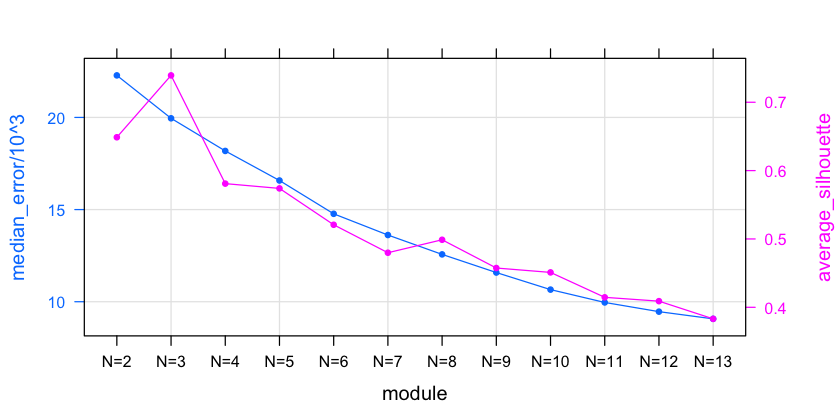

In [425]:
estimation<-module_estimation_Liver[[1]]
estimation$module<-factor(estimation$module,levels=as.factor(estimation$module))
options(repr.plot.width=7, repr.plot.height=3.5)
    obj1 <- xyplot(median_error/10**3 ~ module, estimation, type = c("p", "l"), lwd=1,pch=20,grid = TRUE)
    obj2 <- xyplot(average_silhouette ~ module, estimation, type = c("p", "l"), pch=20,lwd=1)
    plot<-doubleYScale(obj1, obj2, add.ylab2 = TRUE)
plot
estimation

#### The N=6 will chosen for the number of signature in Liver cancer.

In [564]:
isig<-module_estimation_Liver[[3]]
correct_isig<-isig[[6]]
all_iSig<-cbind(all_iSig,correct_isig) ## to take all the signatures found in each cancer type
head(correct_isig,2)

known_cosmic<-cosmic30
known_cosmic_bycol<-t(known_cosmic)
colnames(known_cosmic_bycol)<-paste("sig",rownames(known_cosmic),sep="_")
rownames(known_cosmic_bycol)<-NULL

#simlarity_sig(known_cosmic_bycol,8,8,5,5)
mix<-cbind(correct_isig,known_cosmic_bycol)
print ("How many known signatures similar to isig:")
simlarity_sig(mix,5,5,5,5)

isig_1,isig_2,isig_3,isig_4,isig_5,isig_6
0.009217751,0.020599822,0.014420829,0.02039337,0.04043862,0.009528845
0.010988667,0.009302568,0.007934993,0.02620761,0.01052781,0.004413907


[1] "How many known signatures similar to isig:"
[1] "isig_2"           "sig_16"           "0.94675772862012"
[1] "isig_3"            "sig_12"            "0.965610211997575"
[1] "isig_3"            "sig_16"            "0.911025432979957"
[1] "isig_6"            "sig_6"             "0.910082492459354"


[1] "isig_2"           "sig_16"           "0.94675772862012"
[1] "isig_3"            "sig_12"            "0.965610211997575"
[1] "isig_3"            "sig_16"            "0.911025432979957"
[1] "isig_6"            "sig_6"             "0.910082492459354"


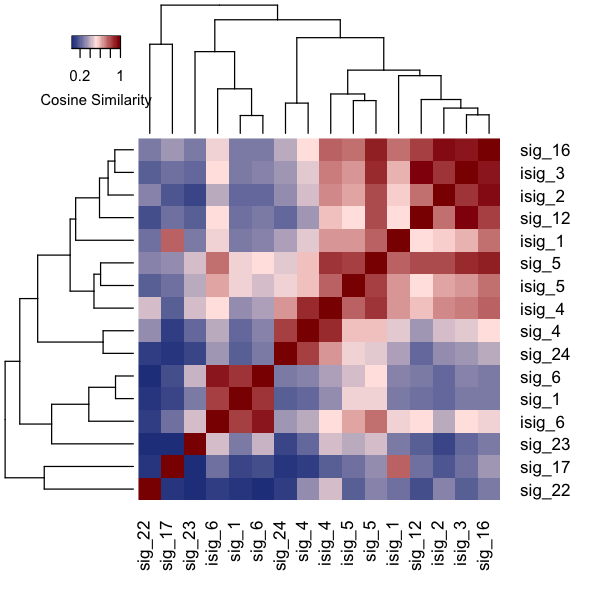

In [504]:
target_known_cosmic<-cosmic30[c(1,4,5,6,12,16,17,22,23,24),]
target_known_cosmic_bycol<-t(target_known_cosmic)
colnames(target_known_cosmic_bycol)<-paste("sig",rownames(target_known_cosmic),sep="_")
rownames(known_cosmic_bycol)<-NULL
mix<-cbind(correct_isig,target_known_cosmic_bycol)
simlarity_sig(mix,5,5,5,5,"Y")

#### There are 10+ signatures being reported in Liver. If we use 0.9 as threshold for signature identification, we could only find sig6, sig12 and sig 16, even the last two signatures are only being found in liver cancer. From the heatmap, we could see that isig4 vs. sig4, isig5 vs. sig5 are both very similar as well.

### LungAdeno

In [426]:
cancer_type<-left_cancer_types[5]
cancer_type
dataset<-as.matrix(wgs_somaticMutation[wgs_somaticMutation$cancer_type==cancer_type,2:97])
colnames(dataset)<-NULL
rownames(dataset)<-NULL
dataset<-t(dataset)
dim(dataset)
module_range<-2:13

[1] "LungAdeno"

[1] 96 51

In [427]:
module_estimation_LungAdeno<-Module_estimation(dataset,module_range)

module,median_error,average_silhouette,improved_construction
N=2,44431.447,0.5265213,1.00000000
N=3,33901.819,0.6763189,0.23698593
N=4,21129.065,0.8281233,0.37675717
N=5,18964.391,0.7259383,0.10245007
N=6,16272.248,0.6094771,0.14195781
N=7,14319.768,0.6479544,0.11998833
N=8,12714.023,0.5229931,0.11213485
N=9,11966.852,0.5633953,0.05876748
N=10,9668.137,0.4549222,0.19209022
N=11,8584.364,0.4454696,0.11209737


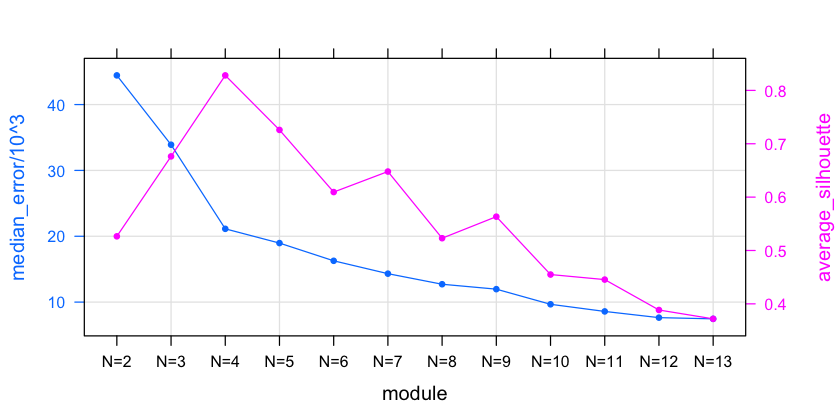

In [428]:
estimation<-module_estimation_LungAdeno[[1]]
estimation$module<-factor(estimation$module,levels=as.factor(estimation$module))
options(repr.plot.width=7, repr.plot.height=3.5)
    obj1 <- xyplot(median_error/10**3 ~ module, estimation, type = c("p", "l"), lwd=1,pch=20,grid = TRUE)
    obj2 <- xyplot(average_silhouette ~ module, estimation, type = c("p", "l"), pch=20,lwd=1)
    plot<-doubleYScale(obj1, obj2, add.ylab2 = TRUE)
plot
estimation

### N=4 looks very likely to be the correct model.

In [565]:
isig<-module_estimation_LungAdeno[[3]]
correct_isig<-isig[[4]]
all_iSig<-cbind(all_iSig,correct_isig) ## to take all the signatures found in each cancer type
head(correct_isig,2)

known_cosmic<-cosmic30
known_cosmic_bycol<-t(known_cosmic)
colnames(known_cosmic_bycol)<-paste("sig",rownames(known_cosmic),sep="_")
rownames(known_cosmic_bycol)<-NULL

#simlarity_sig(known_cosmic_bycol,8,8,5,5)
mix<-cbind(correct_isig,known_cosmic_bycol)
print ("How many known signatures similar to isig:")
simlarity_sig(mix,5,5,5,5)

isig_1,isig_2,isig_3,isig_4
0.010147557,0.04735662,0.0018612742,0.018653437
0.006406342,0.02682590,0.0007374628,0.009318184


[1] "How many known signatures similar to isig:"
[1] "isig_2"            "sig_4"             "0.964411016168533"
[1] "isig_4"            "sig_5"             "0.938794234052679"


[1] "isig_2"            "sig_4"             "0.964411016168533"
[1] "isig_4"            "sig_5"             "0.938794234052679"


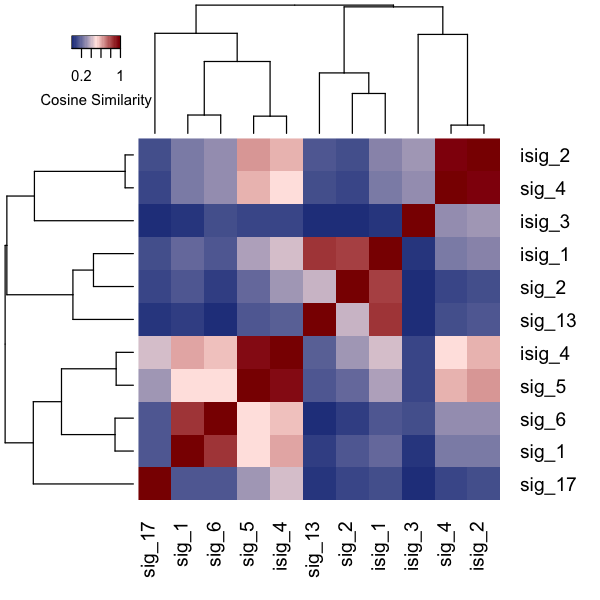

In [508]:
target_known_cosmic<-cosmic30[c(1,2,4,5,6,13,17),]
target_known_cosmic_bycol<-t(target_known_cosmic)
colnames(target_known_cosmic_bycol)<-paste("sig",rownames(target_known_cosmic),sep="_")
rownames(known_cosmic_bycol)<-NULL
mix<-cbind(correct_isig,target_known_cosmic_bycol)
simlarity_sig(mix,5,5,5,5,"Y")

#### There are only two signature have been found here sig4 (isig2) and sig5 (isig4), plus that isig1 which is close to sig2 based on the cluster result.

In [429]:
cancer_type<-left_cancer_types[6]
cancer_type
dataset<-as.matrix(wgs_somaticMutation[wgs_somaticMutation$cancer_type==cancer_type,2:97])
colnames(dataset)<-NULL
rownames(dataset)<-NULL
dataset<-t(dataset)
dim(dataset)
module_range<-2:13

[1] "LymphomaB-cell"

[1] 96 24

In [430]:
module_estimation_LymphomaB_cell<-Module_estimation(dataset,module_range)

module,median_error,average_silhouette,improved_construction
N=2,5104.6786,0.6203130,1.00000000
N=3,3005.3369,0.7043260,0.41125834
N=4,2531.6678,0.6895735,0.15760933
N=5,2008.5149,0.6474009,0.20664358
N=6,1636.3680,0.5365778,0.18528460
N=7,1341.2114,0.4018940,0.18037301
N=8,1189.7158,0.4836714,0.11295430
N=9,1141.1998,0.4223851,0.04077948
N=10,997.4123,0.3273052,0.12599678
N=11,914.1611,0.3382433,0.08346717


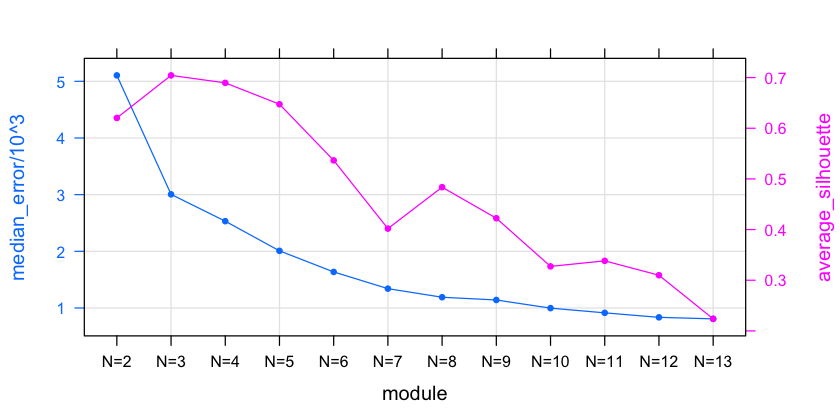

In [431]:
estimation<-module_estimation_LymphomaB_cell[[1]]
estimation$module<-factor(estimation$module,levels=as.factor(estimation$module))
options(repr.plot.width=7, repr.plot.height=3.5)
    obj1 <- xyplot(median_error/10**3 ~ module, estimation, type = c("p", "l"), lwd=1,pch=20,grid = TRUE)
    obj2 <- xyplot(average_silhouette ~ module, estimation, type = c("p", "l"), pch=20,lwd=1)
    plot<-doubleYScale(obj1, obj2, add.ylab2 = TRUE)
plot
estimation

#### N=4

In [566]:
isig<-module_estimation_LymphomaB_cell[[3]]
correct_isig<-isig[[4]]
all_iSig<-cbind(all_iSig,correct_isig) ## to take all the signatures found in each cancer type
head(correct_isig,2)

known_cosmic<-cosmic30
known_cosmic_bycol<-t(known_cosmic)
colnames(known_cosmic_bycol)<-paste("sig",rownames(known_cosmic),sep="_")
rownames(known_cosmic_bycol)<-NULL

#simlarity_sig(known_cosmic_bycol,8,8,5,5)
mix<-cbind(correct_isig,known_cosmic_bycol)
print ("How many known signatures similar to isig:")
simlarity_sig(mix,5,5,5,5)

isig_1,isig_2,isig_3,isig_4
0.005698478,0.0173446,0.005670217,0.01790922
0.005400692,0.0113782,0.004900587,0.01537687


[1] "How many known signatures similar to isig:"
[1] "isig_1"            "sig_9"             "0.980699882593857"
[1] "isig_2"            "sig_5"             "0.909917034393145"


[1] "isig_1"            "sig_9"             "0.980699882593857"
[1] "isig_2"            "sig_5"             "0.909917034393145"


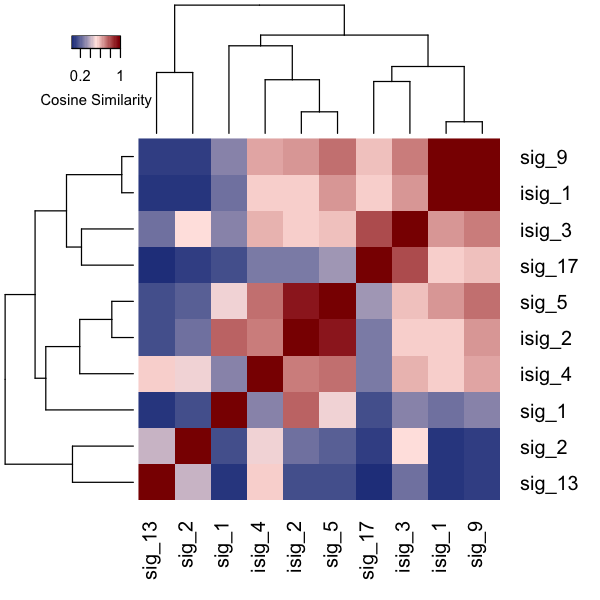

In [520]:
target_known_cosmic<-cosmic30[c(1,2,5,9,13,17),]
target_known_cosmic_bycol<-t(target_known_cosmic)
colnames(target_known_cosmic_bycol)<-paste("sig",rownames(target_known_cosmic),sep="_")
rownames(known_cosmic_bycol)<-NULL
mix<-cbind(correct_isig,target_known_cosmic_bycol)
simlarity_sig(mix,5,5,5,5,"Y")

#### There are 6 signatures being found in Lymphoma B cell (sig 1/2/5/9/13/17). Here we found sig5 and sig9, and also isig3 is similar to sig17.

In [432]:
cancer_type<-left_cancer_types[7]
cancer_type
dataset<-as.matrix(wgs_somaticMutation[wgs_somaticMutation$cancer_type==cancer_type,2:97])
colnames(dataset)<-NULL
rownames(dataset)<-NULL
dataset<-t(dataset)
dim(dataset)
module_range<-2:13

[1] "Medulloblastoma"

[1] 96 40

In [433]:
module_estimation_Medulloblastoma<-Module_estimation(dataset,module_range)

module,median_error,average_silhouette,improved_construction
N=2,2468.658,0.9752327,1.00000000
N=3,2202.584,0.6386662,0.10778081
N=4,2059.223,0.5634885,0.06508767
N=5,1838.430,0.4420209,0.10722142
N=6,1744.981,0.4638211,0.05083098
N=7,1649.076,0.4170226,0.05496025
N=8,1553.690,0.3801405,0.05784217
N=9,1503.496,0.2228372,0.03230623
N=10,1462.574,0.3444170,0.02721801
N=11,1393.586,0.2955414,0.04716911


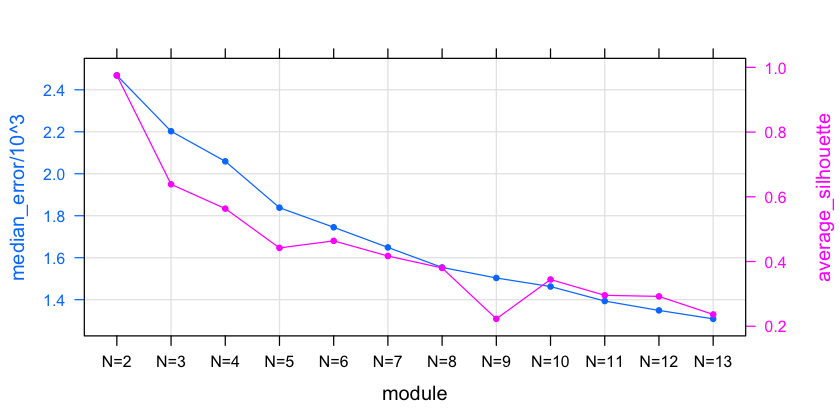

In [434]:
estimation<-module_estimation_Medulloblastoma[[1]]
estimation$module<-factor(estimation$module,levels=as.factor(estimation$module))
options(repr.plot.width=7, repr.plot.height=3.5)
    obj1 <- xyplot(median_error/10**3 ~ module, estimation, type = c("p", "l"), lwd=1,pch=20,grid = TRUE)
    obj2 <- xyplot(average_silhouette ~ module, estimation, type = c("p", "l"), pch=20,lwd=1)
    plot<-doubleYScale(obj1, obj2, add.ylab2 = TRUE)
plot
estimation

#### N=3 will be taken as the correct answer

In [567]:
isig<-module_estimation_Medulloblastoma[[3]]
correct_isig<-isig[[3]]
all_iSig<-cbind(all_iSig,correct_isig) ## to take all the signatures found in each cancer type
head(correct_isig,2)

known_cosmic<-cosmic30
known_cosmic_bycol<-t(known_cosmic)
colnames(known_cosmic_bycol)<-paste("sig",rownames(known_cosmic),sep="_")
rownames(known_cosmic_bycol)<-NULL

#simlarity_sig(known_cosmic_bycol,8,8,5,5)
mix<-cbind(correct_isig,known_cosmic_bycol)
print ("How many known signatures similar to isig:")
simlarity_sig(mix,5,5,5,5)

isig_1,isig_2,isig_3
0.01781593,0.02283053,0.02850297
0.01252193,0.02327153,0.01592871


[1] "How many known signatures similar to isig:"
[1] "isig_1"            "sig_1"             "0.972137574536977"
[1] "isig_2"            "sig_3"             "0.903962367858828"
[1] "isig_2"           "sig_8"            "0.92558535229002"


[1] "isig_1"            "sig_1"             "0.972137574536977"
[1] "isig_2"           "sig_8"            "0.92558535229002"


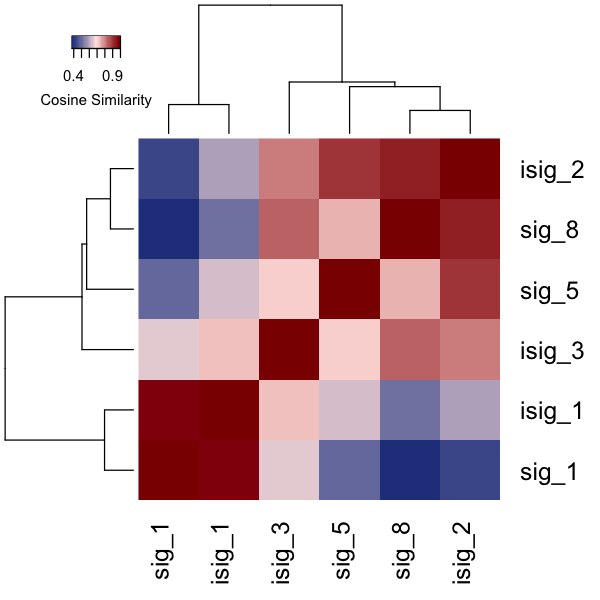

In [522]:
target_known_cosmic<-cosmic30[c(1,5,8),]
target_known_cosmic_bycol<-t(target_known_cosmic)
colnames(target_known_cosmic_bycol)<-paste("sig",rownames(target_known_cosmic),sep="_")
rownames(known_cosmic_bycol)<-NULL
mix<-cbind(correct_isig,target_known_cosmic_bycol)
simlarity_sig(mix,5,5,5,5,"Y")

#### There are three signatures have been found in Medulloblastoma (sig1/5/8). Sig3 is not in the list but has been found here becuase it is very similar to sig8 which is closer to our isig2. So there are two signatures being found here sig1 and sig 8.

### Melanoma

In [435]:
cancer_type<-left_cancer_types[8]
cancer_type
dataset<-as.matrix(wgs_somaticMutation[wgs_somaticMutation$cancer_type==cancer_type,2:97])
colnames(dataset)<-NULL
rownames(dataset)<-NULL
dataset<-t(dataset)
dim(dataset)
module_range<-2:13

[1] "Melanoma"

[1] 96 59

In [436]:
module_estimation_Melanoma<-Module_estimation(dataset,module_range)

module,median_error,average_silhouette,improved_construction
N=2,6345.208,0.8842728,1.000000000
N=3,5254.176,0.8839939,0.171945810
N=4,4570.241,0.8714393,0.130169836
N=5,3579.679,0.6540497,0.216741611
N=6,3392.707,0.5484339,0.052231518
N=7,2927.897,0.5106438,0.137002815
N=8,2707.928,0.4571075,0.075128455
N=9,2328.245,0.4302663,0.140211831
N=10,2200.739,0.3466097,0.054764660
N=11,2099.414,0.4688346,0.046041667


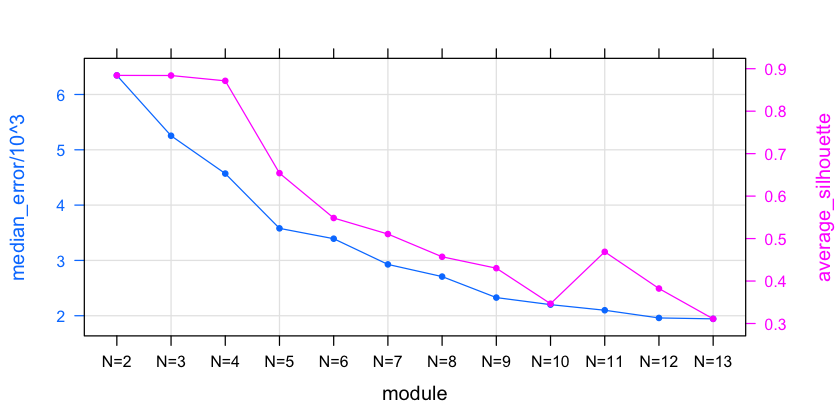

In [437]:
estimation<-module_estimation_Melanoma[[1]]
estimation$module<-factor(estimation$module,levels=as.factor(estimation$module))
options(repr.plot.width=7, repr.plot.height=3.5)
    obj1 <- xyplot(median_error/10**3 ~ module, estimation, type = c("p", "l"), lwd=1,pch=20,grid = TRUE)
    obj2 <- xyplot(average_silhouette ~ module, estimation, type = c("p", "l"), pch=20,lwd=1)
    plot<-doubleYScale(obj1, obj2, add.ylab2 = TRUE)
plot
estimation

#### N=4

In [568]:
isig<-module_estimation_Melanoma[[3]]
correct_isig<-isig[[4]]
all_iSig<-cbind(all_iSig,correct_isig) ## to take all the signatures found in each cancer type
head(correct_isig,2)

known_cosmic<-cosmic30
known_cosmic_bycol<-t(known_cosmic)
colnames(known_cosmic_bycol)<-paste("sig",rownames(known_cosmic),sep="_")
rownames(known_cosmic_bycol)<-NULL

#simlarity_sig(known_cosmic_bycol,8,8,5,5)
mix<-cbind(correct_isig,known_cosmic_bycol)
print ("How many known signatures similar to isig:")
simlarity_sig(mix,5,5,5,5)

isig_1,isig_2,isig_3,isig_4
0.0010113026,0.0003739575,0.022515281,0.0024415117
0.0007615245,0.0007239681,0.002233552,0.0006048728


[1] "How many known signatures similar to isig:"
[1] "isig_1"            "sig_7"             "0.999492646459295"
[1] "isig_2"            "sig_11"            "0.977857453040701"


[1] "isig_1"            "sig_7"             "0.999492646459295"
[1] "isig_2"            "sig_11"            "0.977857453040701"


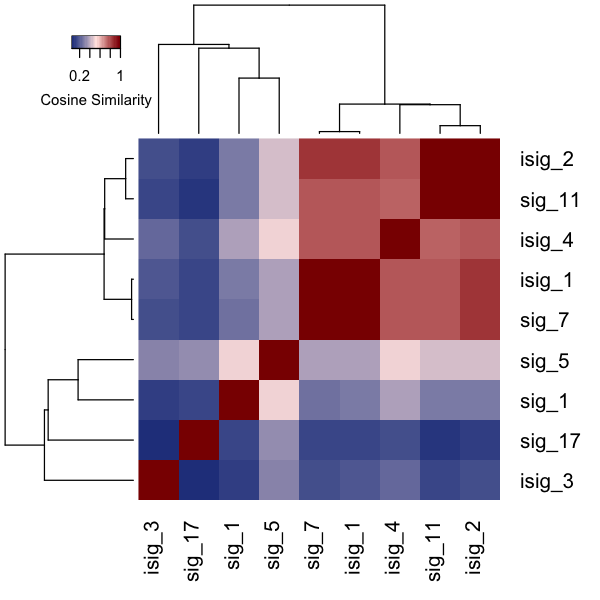

In [525]:
target_known_cosmic<-cosmic30[c(1,5,7,11,17),]
target_known_cosmic_bycol<-t(target_known_cosmic)
colnames(target_known_cosmic_bycol)<-paste("sig",rownames(target_known_cosmic),sep="_")
rownames(known_cosmic_bycol)<-NULL
mix<-cbind(correct_isig,target_known_cosmic_bycol)
simlarity_sig(mix,5,5,5,5,"Y")

#### Among the known signatures (sig 1/5/7/11/17) in Melonoma, there are two being found sig7 and sig 11.

#### Pancreas

In [438]:
cancer_type<-left_cancer_types[9]
cancer_type
dataset<-as.matrix(wgs_somaticMutation[wgs_somaticMutation$cancer_type==cancer_type,2:97])
colnames(dataset)<-NULL
rownames(dataset)<-NULL
dataset<-t(dataset)
dim(dataset)
module_range<-2:13

[1] "Pancreas"

[1] 96 14

In [439]:
module_estimation_Pancreas<-Module_estimation(dataset,module_range)

module,median_error,average_silhouette,improved_construction
N=2,4026.5115,0.4507220,1.00000000
N=3,2177.5424,0.7186237,0.45919876
N=4,1942.3450,0.5441372,0.10801047
N=5,1767.5183,0.3103230,0.09000808
N=6,1380.2834,0.4004668,0.21908397
N=7,1102.7529,0.3753607,0.20106772
N=8,956.4603,0.3214541,0.13266132
N=9,777.8660,0.3026865,0.18672423
N=10,616.7739,0.2620823,0.20709490
N=11,574.0971,0.2040509,0.06919358


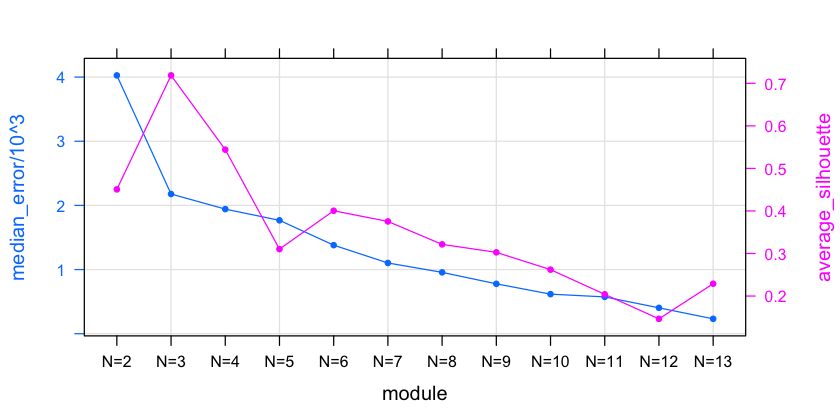

In [440]:
estimation<-module_estimation_Pancreas[[1]]
estimation$module<-factor(estimation$module,levels=as.factor(estimation$module))
options(repr.plot.width=7, repr.plot.height=3.5)
    obj1 <- xyplot(median_error/10**3 ~ module, estimation, type = c("p", "l"), lwd=1,pch=20,grid = TRUE)
    obj2 <- xyplot(average_silhouette ~ module, estimation, type = c("p", "l"), pch=20,lwd=1)
    plot<-doubleYScale(obj1, obj2, add.ylab2 = TRUE)
plot
estimation

#### N=3

In [569]:
isig<-module_estimation_Pancreas[[3]]
correct_isig<-isig[[3]]
all_iSig<-cbind(all_iSig,correct_isig) ## to take all the signatures found in each cancer type
head(correct_isig,2)

known_cosmic<-cosmic30
known_cosmic_bycol<-t(known_cosmic)
colnames(known_cosmic_bycol)<-paste("sig",rownames(known_cosmic),sep="_")
rownames(known_cosmic_bycol)<-NULL

#simlarity_sig(known_cosmic_bycol,8,8,5,5)
mix<-cbind(correct_isig,known_cosmic_bycol)
print ("How many known signatures similar to isig:")
simlarity_sig(mix,5,5,5,5)

isig_1,isig_2,isig_3
0.001973245,0.0008474614,0.04489871
0.002847116,0.0006267700,0.02616579


[1] "How many known signatures similar to isig:"
[1] "isig_3"            "sig_4"             "0.946768208303718"


[1] "isig_2"            "sig_3"             "0.940150671129499"


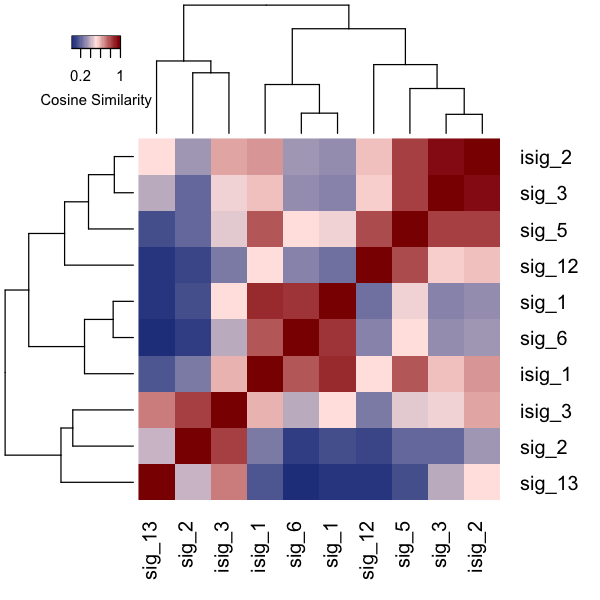

In [527]:
target_known_cosmic<-cosmic30[c(1,2,3,5,6,12,13),]
target_known_cosmic_bycol<-t(target_known_cosmic)
colnames(target_known_cosmic_bycol)<-paste("sig",rownames(target_known_cosmic),sep="_")
rownames(known_cosmic_bycol)<-NULL
mix<-cbind(correct_isig,target_known_cosmic_bycol)
simlarity_sig(mix,5,5,5,5,"Y")

#### Sig3 has been found as isig2. Also, isig3 and isig1 are very similar to sig13 and sig1, respectively.

### Comment on problem 2a:

#### From all the cancer types whose data is available, all our inferred signatures are the signatures have been reported in the specific cancer type. But the known signatures are not always being found by our inferrence partly due to the small sample size, partly due to the limit of the inference method. However, as a trial version of signature identification, the result is not bad either. What very intresting is that sig1 and sig5 are supposed to be found in all the cancer types, but they are missing in lots of cases here. So far, I have no idea about why they are not being detected.

#### Problem 2b:
Perform hierarchical clustering of the signatures that you found from different cancer types. Then form a mean signature for each cluster (use 0.9 or higher cosine similarity as a cut off). Compare these mean signatures to the 30 signatures given.

In [570]:
## we have collected all the inferred signatures as all_iSig
head(all_iSig,2)
dim(all_iSig)

isig_1,isig_2,isig_3,isig_4,isig_5,isig_6,isig_7,isig_1,isig_2,isig_3,⋯,isig_1,isig_2,isig_3,isig_1,isig_2,isig_3,isig_4,isig_1,isig_2,isig_3
0.003617144,0.03306991,0.003438375,0.05010626,0.01226459,0.002426267,0.04385857,0.016087568,0.01832009,0.008269084,⋯,0.01781593,0.02283053,0.02850297,0.0010113026,0.0003739575,0.022515281,0.0024415117,0.001973245,0.0008474614,0.04489871
0.004527757,0.01197963,0.001433250,0.02483712,0.01635556,0.009958667,0.02025810,0.007294883,0.01408525,0.006393766,⋯,0.01252193,0.02327153,0.01592871,0.0007615245,0.0007239681,0.002233552,0.0006048728,0.002847116,0.0006267700,0.02616579


[1] 96 42

[1] "isig_3"            "isig_25"           "0.938351597298924"
[1] "isig_3"            "isig_41"           "0.935527006132368"
[1] "isig_5"            "isig_34"           "0.954224595770825"
[1] "isig_6"            "isig_33"           "0.963353693879414"
[1] "isig_8"            "isig_29"           "0.924582855675852"
[1] "isig_9"            "isig_28"           "0.945379398404744"
[1] "isig_9"            "isig_30"           "0.987718251966735"
[1] "isig_25"           "isig_41"           "0.944579411664347"
[1] "isig_26"           "isig_42"           "0.989877784924935"
[1] "isig_28"           "isig_30"           "0.941003066262135"


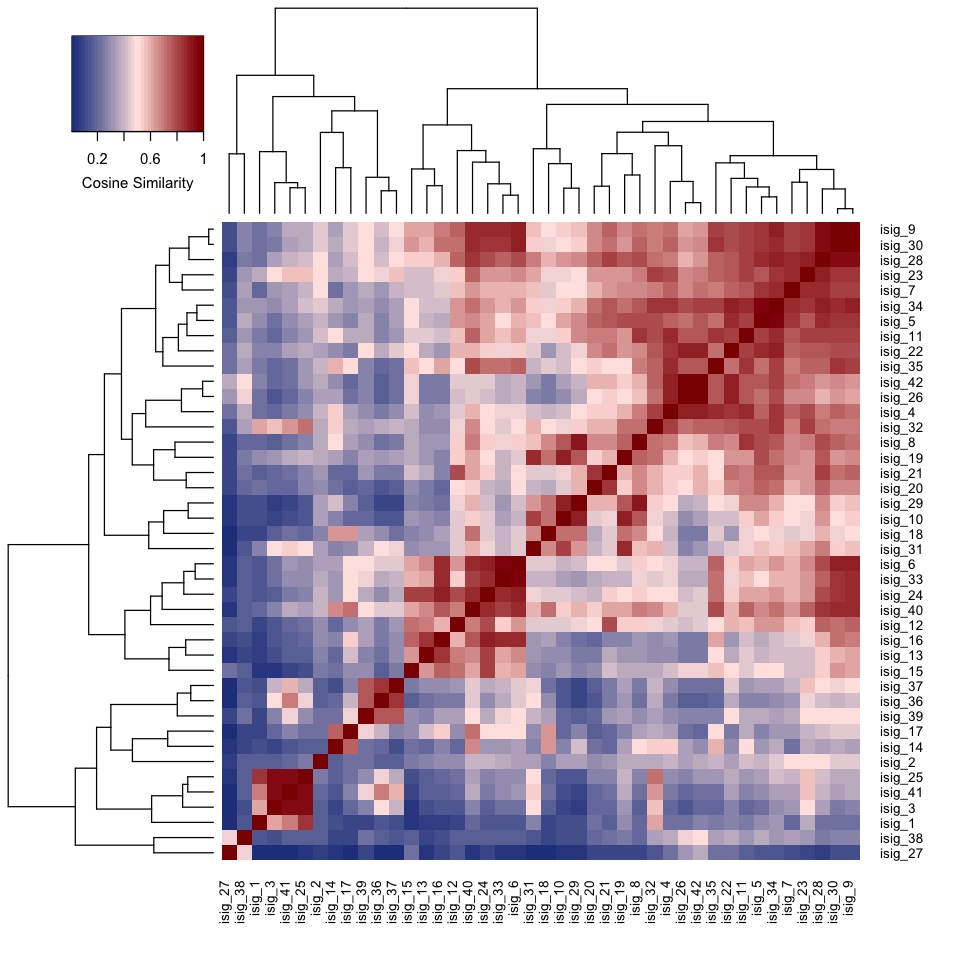

In [571]:
colnames(all_iSig)<-paste("isig",1:dim(all_iSig)[2],sep="_")
simlarity_sig(all_iSig,8,8,5,5,"Y")

#### There are 6 groups containing 14 isignatures based on the 0.9 cutoff. We have 42 isignatures in total, so there are 42-14 =28, 28+6=34 groups. I will cut the ht cluster into 34 clusters and get the average mean if there are a few signatures within one group. Then we will map the 34 signatures back to 30 known cosimic signatures.

In [578]:
data<-as.matrix(all_iSig)
number_sig<-dim(data)[2]
    
dis_matrix<-matrix(replicate(number_sig*number_sig,0),ncol=number_sig) ## creat distance matrix    
    
for (i in 1:number_sig){ ## fisrt loop
        pred_sig<-as.matrix(data[,i])
        for (j in 1:number_sig){ ## second loop
            picked_sig<-as.matrix(data[,j])
            dis_matrix[i,j]<-cosine_similarity(pred_sig,picked_sig)              
        }
    }
    
## assign sig names:
colnames(dis_matrix)<-NULL
rownames(dis_matrix)<-NULL
#print(dis_matrix)    
    
## make dist matrix for headmap, here we use consine-similarity matrix, larger number means closer relationship.
dis_matrix_copy<-as.matrix(dis_matrix)    
dis_matrix<- as.dist(as.matrix(dis_matrix))
    
## for the tree cut method hclust and cutree, we are using 1-dis_matrix because the distance matrix used here
## should be used to describe the distance. it means larger value and larger distance. So we used 1-dis_matrix.
hr <- hclust(1-dis_matrix, method="complete")
ct<-cutree(hr, k=34)

In [592]:
new_all_iSig<-matrix(replicate(96*34,0),ncol=i)
   
for (sig_order in 1:34){
    group_ids<-colnames(all_iSig)[ct==sig_order]
    print (c(sig_order,group_ids))
    sig<-all_iSig[,ct==sig_order]
    if (sum(all_iSig[,ct==sig_order])>1){ ## there are more than 2 signatures in i group
        sum_sig<-apply(sig,2,sum)
        normarlise_sig<-apply(sig,1,function(x) x/sum_sig)
        normarlise_sig<-t(normarlise_sig)
        new_all_iSig[,sig_order]<-as.vector(apply(normarlise_sig,1,mean))
    }else if (sum(all_iSig[,ct==sig_order])==1){
        new_all_iSig[,sig_order]<-sig     
    }    
}
#        print(sig_matrix)
sig_id<-paste("isig",1:34,sep="_")
colnames(new_all_iSig)<-sig_id     
head(new_all_iSig)

[1] "1"      "isig_1"
[1] "2"      "isig_2"
[1] "3"       "isig_3"  "isig_25" "isig_41"
[1] "4"      "isig_4"
[1] "5"       "isig_5"  "isig_34"
[1] "6"       "isig_6"  "isig_33"
[1] "7"      "isig_7"
[1] "8"       "isig_8"  "isig_29"
[1] "9"       "isig_9"  "isig_28" "isig_30"
[1] "10"      "isig_10"
[1] "11"      "isig_11"
[1] "12"      "isig_12"
[1] "13"      "isig_13"
[1] "14"      "isig_14"
[1] "15"      "isig_15"
[1] "16"      "isig_16"
[1] "17"      "isig_17"
[1] "18"      "isig_18"
[1] "19"      "isig_19"
[1] "20"      "isig_20"
[1] "21"      "isig_21"
[1] "22"      "isig_22"
[1] "23"      "isig_23"
[1] "24"      "isig_24"
[1] "25"      "isig_26" "isig_42"
[1] "26"      "isig_27"
[1] "27"      "isig_31"
[1] "28"      "isig_32"
[1] "29"      "isig_35"
[1] "30"      "isig_36"
[1] "31"      "isig_37"
[1] "32"      "isig_38"
[1] "33"      "isig_39"
[1] "34"      "isig_40"


isig_1,isig_2,isig_3,isig_4,isig_5,isig_6,isig_7,isig_8,isig_9,isig_10,⋯,isig_25,isig_26,isig_27,isig_28,isig_29,isig_30,isig_31,isig_32,isig_33,isig_34
0.0036171443,0.033069908,0.0048111311,0.050106257,0.017547560,0.010121098,0.043858568,0.0108930234,0.018106043,0.0082690839,⋯,0.046127667,0.0018612742,0.0056702167,0.017909217,0.028502970,0.0010113026,0.0003739575,0.022515281,0.0024415117,0.001973245
0.0045277571,0.011979634,0.0028221206,0.024837116,0.019813544,0.011240299,0.020258105,0.0063477878,0.011593878,0.0063937660,⋯,0.026495847,0.0007374628,0.0049005865,0.015376865,0.015928710,0.0007615245,0.0007239681,0.002233552,0.0006048728,0.002847116
0.0005092026,0.002596837,0.0009670721,0.002952566,0.001860427,0.002471433,0.003695148,0.0009003996,0.001940480,0.0004337668,⋯,0.009099534,0.0001818479,0.0002236398,0.002017552,0.001136626,0.0002718166,0.0002123447,0.003425643,0.0003429668,0.000169991
0.0026760079,0.008623416,0.0026283598,0.024067282,0.019607918,0.007397505,0.018889386,0.0063933377,0.011315174,0.0060595820,⋯,0.030050582,0.0010853443,0.0046669678,0.015102113,0.016151228,0.0007481315,0.0004612583,0.007377765,0.0020161442,0.004998180
0.0081367132,0.012083317,0.0038393254,0.036670424,0.018197398,0.006512529,0.017098498,0.0087753695,0.013723211,0.0070107658,⋯,0.055723263,0.2833665253,0.0057596628,0.020249504,0.041087648,0.0025683166,0.0016115501,0.141679313,0.0117729347,0.002209274
0.0045846522,0.005935068,0.0029187085,0.017245879,0.017393783,0.004879180,0.010359776,0.0058270558,0.007579503,0.0027925730,⋯,0.046111249,0.0350709009,0.0027802389,0.009730393,0.013989581,0.0012272123,0.0021655250,0.021544977,0.0054853806,0.002154538


[1] "How many known signatures similar to isig:"
[1] "isig_1"            "sig_13"            "0.993254322986607"
[1] "isig_3"            "sig_2"             "0.910619688506683"
[1] "isig_4"            "sig_8"             "0.915298900856184"
[1] "isig_5"            "sig_3"             "0.931818374560867"
[1] "isig_5"            "sig_5"             "0.913108249312464"
[1] "isig_6"           "sig_1"            "0.95592239603185"
[1] "isig_8"            "sig_9"             "0.987561842888765"
[1] "isig_9"            "sig_5"             "0.933525788676088"
[1] "isig_10"           "sig_9"             "0.909598171873316"
[1] "isig_13"           "sig_15"            "0.963808894132409"
[1] "isig_14"           "sig_10"            "0.981185171445362"
[1] "isig_16"           "sig_1"             "0.900368971449288"
[1] "isig_16"           "sig_6"             "0.964222992074822"
[1] "isig_20"          "sig_16"           "0.94675772862012"
[1] "isig_21"           "sig_12"            "0.96561021199757

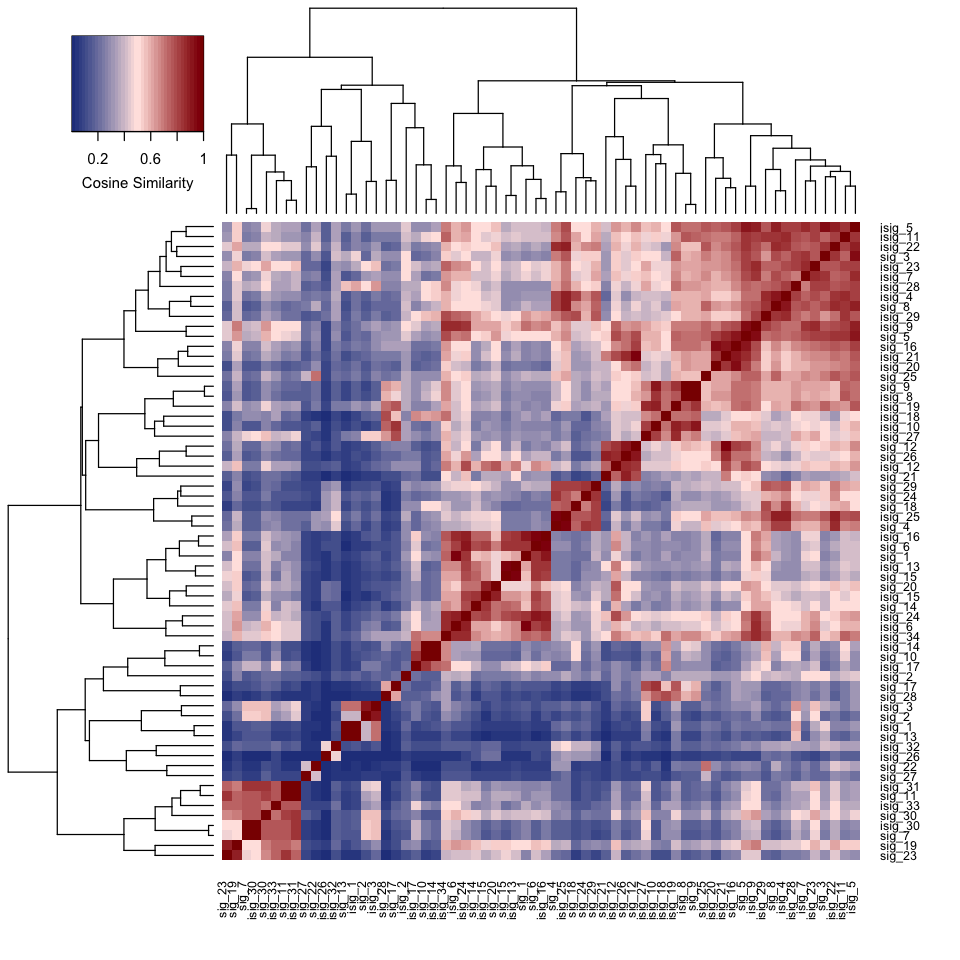

In [594]:
known_cosmic<-cosmic30
known_cosmic_bycol<-t(known_cosmic)
colnames(known_cosmic_bycol)<-paste("sig",rownames(known_cosmic),sep="_")
rownames(known_cosmic_bycol)<-NULL

#simlarity_sig(known_cosmic_bycol,8,8,5,5)
mix<-cbind(new_all_iSig,known_cosmic_bycol)
print ("How many known signatures similar to isig:")
simlarity_sig(mix,8,8,5,5,"Y")

#### Based on the above result, we have found out 15 out of 30 known signatures from the WGS dataset (without any repeat, see below):

#### 1)  isig_1 -- sig_13;   2) isig_3 -- sig_2;   3) isig_4 -- sig8;   4) isig_5 -- sig_3;   5) isig_6 -- sig_1;   6) isig_8 -- sig_9;   7) isig_9 -- sig_5
#### 8)  isig_13 -- sig_15   9) isig_14 -- sig10;   10) isig_16 -- sig_6;   11) isig_20 -- sig_16;     12) isig_21 -- sig_12;   13 ) isig_25 -- sig_4
#### 14) isig_30 -- sig_7;    15) isig 31 -- sig_11


#### Problem 2c:
Try to do the inference across all cancer types at once. How many good matches you find when you compare to the 30 given signatures (cosine similarity > 0.9). Comment why this way of doing the inference is difficult (or is it?). 

In [546]:
dim(wgs_somaticMutation)

[1] 487  98

In [547]:
dataset<-as.matrix(wgs_somaticMutation[,2:97])
colnames(dataset)<-NULL
rownames(dataset)<-NULL
dataset<-t(dataset)
dim(dataset)
module_range<-2:13

[1]  96 487

In [548]:
## Very time consuming:
module_estimation_all<-Module_estimation(dataset,module_range)

In [549]:
module_estimation_all<-module_estimation_Pancreas

module,median_error,average_silhouette,improved_construction
N=2,335698.79,0.7105470,1.00000000
N=3,264756.35,0.7743423,0.21132766
N=4,212447.52,0.9321370,0.19757347
N=5,183756.35,0.7665827,0.13505063
N=6,141157.75,0.7697642,0.23182111
N=7,113128.08,0.6564692,0.19856979
N=8,106871.99,0.8311264,0.05530101
N=9,97040.78,0.8159403,0.09199053
N=10,91054.90,0.6658097,0.06168417
N=11,85742.89,0.6834991,0.05833846


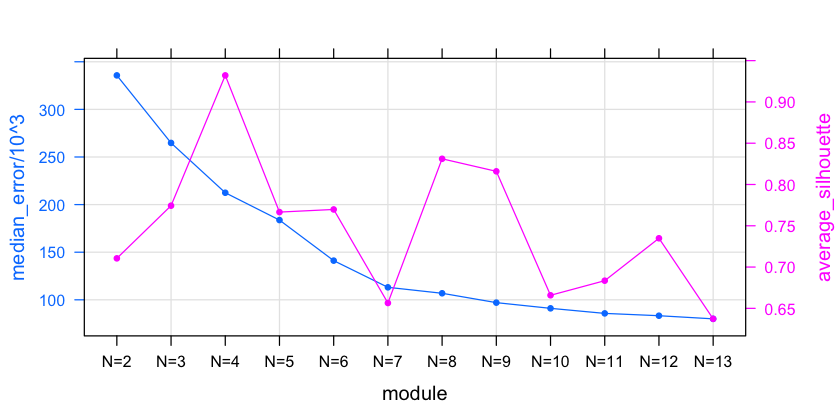

In [551]:
estimation<-module_estimation_all[[1]]
estimation$module<-factor(estimation$module,levels=as.factor(estimation$module))
options(repr.plot.width=7, repr.plot.height=3.5)
    obj1 <- xyplot(median_error/10**3 ~ module, estimation, type = c("p", "l"), lwd=1,pch=20,grid = TRUE)
    obj2 <- xyplot(average_silhouette ~ module, estimation, type = c("p", "l"), pch=20,lwd=1)
    plot<-doubleYScale(obj1, obj2, add.ylab2 = TRUE)
plot
estimation

#### N=8

In [554]:
isig<-module_estimation_all[[3]]
correct_isig<-isig[[8]]
head(correct_isig,2)

known_cosmic<-cosmic30
known_cosmic_bycol<-t(known_cosmic)
colnames(known_cosmic_bycol)<-paste("sig",rownames(known_cosmic),sep="_")
rownames(known_cosmic_bycol)<-NULL

#simlarity_sig(known_cosmic_bycol,8,8,5,5)
mix<-cbind(correct_isig,known_cosmic_bycol)
print ("How many known signatures similar to isig:")
simlarity_sig(mix,8,8,5,5)

isig_1,isig_2,isig_3,isig_4,isig_5,isig_6,isig_7,isig_8
4.113175e-05,0.02130297,0.0010236975,0.05628881,0.007438347,0.0003835904,0.002270847,0.0020551680
1.953654e-03,0.02020867,0.0006933363,0.03024398,0.003509224,0.0012264714,0.002758504,0.0006503508


[1] "How many known signatures similar to isig:"
[1] "isig_1"            "sig_1"             "0.912713141588777"
[1] "isig_1"            "sig_6"             "0.961378338932489"
[1] "isig_4"           "sig_4"            "0.96471856506979"
[1] "isig_5"            "sig_12"            "0.946155153296431"
[1] "isig_5"            "sig_16"            "0.916439319024171"
[1] "isig_6"            "sig_10"            "0.998487575625334"


#### When we use all the cancer types as a whole dataset for the inference, we could only find four signatures out of 30:

#### 1) isig_1 -- sig_6;    2) isig4 --sig 4       3) isig5 -- sig 12     4) isig_6 -- sig10

### Comment

#### Based on 2b and 2c, we could conculde that the detection power could be increased dramatically if we use the seperate cancer type amd combine them together as our final signarures.

#### It is probabably because each cancer type has been exposed to different mutagenic processes and containing different biological meanings. If when combine the data together, the biological signal has been diluted by the imbalanced sample sizes collected for different cancer types.